# Mask2Former 

# 0. Импортируем библиотеки и загружаем данные

In [2]:
import os
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultPredictor
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader, DatasetCatalog, MetadataCatalog
from detectron2.utils.visualizer import Visualizer
import torch
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
print("CUDA Available:", torch.cuda.is_available())
print("CUDA Device:", torch.cuda.get_device_name(0))

CUDA Available: True
CUDA Device: NVIDIA GeForce RTX 2070


In [2]:
# Путь к изображениями
image_root = "E:/data/potato_leaf_dataset/images"

In [14]:
%cd mask2former/modeling/pixel_decoder/ops

[WinError 3] Системе не удается найти указанный путь: 'mask2former/modeling/pixel_decoder/ops'
C:\VsCodeProjects\ML\PlantsCV


In [15]:
!pip install -r requirements.txt

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


In [5]:
# Регистрируем COCO-датасет
register_coco_instances("potato_train", {}, "E:/data/potato_leaf_dataset/splits/instances_train.json", image_root)
register_coco_instances("potato_val", {}, "E:/data/potato_leaf_dataset/splits/instances_val.json", image_root)
register_coco_instances("potato_test", {}, "E:/data/potato_leaf_dataset/splits/instances_test.json", image_root)

namespace(name='potato_test',
          json_file='E:/data/potato_leaf_dataset/splits/instances_test.json',
          image_root='E:/data/potato_leaf_dataset/images',
          evaluator_type='coco',
          thing_classes=['leaf'])

# 1. Обучение модели

In [6]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(
    "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
))

cfg.DATASETS.TRAIN = ("potato_train",)
cfg.DATASETS.TEST = ("potato_val",)
cfg.TEST.EVAL_PERIOD = 500
cfg.DATALOADER.NUM_WORKERS = 2  # больше воркеров

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(
    "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
)
cfg.SOLVER.IMS_PER_BATCH = 2  # больше батч
cfg.SOLVER.BASE_LR = 0.001  # lr под размер батча
cfg.SOLVER.MAX_ITER = 5000
cfg.SOLVER.STEPS = [3000, 4500]  # lr decay для лучшего сходимости

cfg.SOLVER.AMP.ENABLED = True  # mixed precision

cfg.INPUT.MIN_SIZE_TRAIN = (800,)
cfg.INPUT.MAX_SIZE_TRAIN = 1333
cfg.INPUT.MAX_SIZE_TEST = 1333

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1

cfg.OUTPUT_DIR = "./output"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)


In [16]:
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[06/16 16:24:19 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:474: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  grad_scaler = GradScaler()
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in

[06/16 16:24:19 d2.engine.train_loop]: Starting training from iteration 0


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\torch\optim\lr_scheduler.py:182: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precis

[06/16 16:24:35 d2.utils.events]:  eta: 0:52:42  iter: 19  total_loss: 3.5  loss_cls: 0.6901  loss_box_reg: 0.6814  loss_mask: 0.6904  loss_rpn_cls: 1.327  loss_rpn_loc: 0.104    time: 0.5579  last_time: 0.4845  data_time: 0.5584  last_data_time: 0.2698   lr: 4.9953e-06  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:24:47 d2.utils.events]:  eta: 0:58:07  iter: 39  total_loss: 3.179  loss_cls: 0.6529  loss_box_reg: 0.7484  loss_mask: 0.6821  loss_rpn_cls: 0.9988  loss_rpn_loc: 0.1107    time: 0.5809  last_time: 0.5863  data_time: 0.3830  last_data_time: 0.3642   lr: 9.9902e-06  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:24:59 d2.utils.events]:  eta: 0:59:44  iter: 59  total_loss: 2.602  loss_cls: 0.595  loss_box_reg: 0.8679  loss_mask: 0.6677  loss_rpn_cls: 0.3901  loss_rpn_loc: 0.07912    time: 0.5836  last_time: 0.7809  data_time: 0.3700  last_data_time: 0.5630   lr: 1.4985e-05  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:25:12 d2.utils.events]:  eta: 1:00:25  iter: 79  total_loss: 2.312  loss_cls: 0.5298  loss_box_reg: 0.8344  loss_mask: 0.6467  loss_rpn_cls: 0.1725  loss_rpn_loc: 0.1096    time: 0.5941  last_time: 0.7527  data_time: 0.4054  last_data_time: 0.5280   lr: 1.998e-05  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:25:23 d2.utils.events]:  eta: 1:00:31  iter: 99  total_loss: 2.111  loss_cls: 0.4893  loss_box_reg: 0.8411  loss_mask: 0.614  loss_rpn_cls: 0.07053  loss_rpn_loc: 0.09396    time: 0.5908  last_time: 0.5891  data_time: 0.3589  last_data_time: 0.3742   lr: 2.4975e-05  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:25:35 d2.utils.events]:  eta: 1:00:06  iter: 119  total_loss: 2.086  loss_cls: 0.4569  loss_box_reg: 0.8664  loss_mask: 0.5908  loss_rpn_cls: 0.04523  loss_rpn_loc: 0.08875    time: 0.5933  last_time: 0.6860  data_time: 0.3855  last_data_time: 0.4617   lr: 2.997e-05  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:25:47 d2.utils.events]:  eta: 0:59:46  iter: 139  total_loss: 1.985  loss_cls: 0.4383  loss_box_reg: 0.8365  loss_mask: 0.5616  loss_rpn_cls: 0.04765  loss_rpn_loc: 0.09162    time: 0.5915  last_time: 0.4875  data_time: 0.3633  last_data_time: 0.2686   lr: 3.4965e-05  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:25:58 d2.utils.events]:  eta: 0:59:15  iter: 159  total_loss: 1.901  loss_cls: 0.4122  loss_box_reg: 0.8393  loss_mask: 0.5142  loss_rpn_cls: 0.03542  loss_rpn_loc: 0.07079    time: 0.5893  last_time: 0.6181  data_time: 0.3566  last_data_time: 0.3985   lr: 3.996e-05  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:26:10 d2.utils.events]:  eta: 0:58:49  iter: 179  total_loss: 1.825  loss_cls: 0.3945  loss_box_reg: 0.8046  loss_mask: 0.4799  loss_rpn_cls: 0.03592  loss_rpn_loc: 0.1047    time: 0.5894  last_time: 0.6042  data_time: 0.3703  last_data_time: 0.3599   lr: 4.4955e-05  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:26:22 d2.utils.events]:  eta: 0:58:37  iter: 199  total_loss: 1.77  loss_cls: 0.3704  loss_box_reg: 0.8031  loss_mask: 0.4222  loss_rpn_cls: 0.03171  loss_rpn_loc: 0.06734    time: 0.5883  last_time: 0.2276  data_time: 0.3457  last_data_time: 0.0016   lr: 4.995e-05  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:26:33 d2.utils.events]:  eta: 0:58:25  iter: 219  total_loss: 1.615  loss_cls: 0.3294  loss_box_reg: 0.78  loss_mask: 0.39  loss_rpn_cls: 0.02192  loss_rpn_loc: 0.0708    time: 0.5866  last_time: 0.2337  data_time: 0.3463  last_data_time: 0.0015   lr: 5.4945e-05  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:26:45 d2.utils.events]:  eta: 0:57:59  iter: 239  total_loss: 1.652  loss_cls: 0.3466  loss_box_reg: 0.7709  loss_mask: 0.4042  loss_rpn_cls: 0.03373  loss_rpn_loc: 0.09029    time: 0.5851  last_time: 0.6839  data_time: 0.3428  last_data_time: 0.4684   lr: 5.994e-05  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:26:57 d2.utils.events]:  eta: 0:57:45  iter: 259  total_loss: 1.551  loss_cls: 0.3229  loss_box_reg: 0.7374  loss_mask: 0.3479  loss_rpn_cls: 0.02619  loss_rpn_loc: 0.07821    time: 0.5869  last_time: 1.0095  data_time: 0.3905  last_data_time: 0.7988   lr: 6.4935e-05  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:27:08 d2.utils.events]:  eta: 0:57:27  iter: 279  total_loss: 1.427  loss_cls: 0.2889  loss_box_reg: 0.7169  loss_mask: 0.3248  loss_rpn_cls: 0.02892  loss_rpn_loc: 0.08075    time: 0.5861  last_time: 0.6455  data_time: 0.3568  last_data_time: 0.4318   lr: 6.993e-05  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:27:21 d2.utils.events]:  eta: 0:57:15  iter: 299  total_loss: 1.371  loss_cls: 0.2861  loss_box_reg: 0.6738  loss_mask: 0.3041  loss_rpn_cls: 0.02814  loss_rpn_loc: 0.06994    time: 0.5882  last_time: 0.2215  data_time: 0.3974  last_data_time: 0.0009   lr: 7.4925e-05  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:27:33 d2.utils.events]:  eta: 0:57:11  iter: 319  total_loss: 1.217  loss_cls: 0.2561  loss_box_reg: 0.6082  loss_mask: 0.2621  loss_rpn_cls: 0.01964  loss_rpn_loc: 0.06437    time: 0.5914  last_time: 0.2184  data_time: 0.4195  last_data_time: 0.0013   lr: 7.992e-05  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:27:45 d2.utils.events]:  eta: 0:56:57  iter: 339  total_loss: 1.193  loss_cls: 0.258  loss_box_reg: 0.5658  loss_mask: 0.2623  loss_rpn_cls: 0.02877  loss_rpn_loc: 0.08503    time: 0.5912  last_time: 0.4430  data_time: 0.3687  last_data_time: 0.2182   lr: 8.4915e-05  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:27:57 d2.utils.events]:  eta: 0:56:48  iter: 359  total_loss: 1.087  loss_cls: 0.2372  loss_box_reg: 0.4991  loss_mask: 0.2299  loss_rpn_cls: 0.02498  loss_rpn_loc: 0.0754    time: 0.5922  last_time: 0.5154  data_time: 0.3916  last_data_time: 0.2884   lr: 8.991e-05  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:28:09 d2.utils.events]:  eta: 0:56:42  iter: 379  total_loss: 1.04  loss_cls: 0.2409  loss_box_reg: 0.4616  loss_mask: 0.228  loss_rpn_cls: 0.02708  loss_rpn_loc: 0.06607    time: 0.5918  last_time: 0.8289  data_time: 0.3644  last_data_time: 0.6052   lr: 9.4905e-05  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:28:21 d2.utils.events]:  eta: 0:56:30  iter: 399  total_loss: 0.9737  loss_cls: 0.232  loss_box_reg: 0.4386  loss_mask: 0.2021  loss_rpn_cls: 0.02231  loss_rpn_loc: 0.05273    time: 0.5916  last_time: 0.2182  data_time: 0.3680  last_data_time: 0.0009   lr: 9.99e-05  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:28:33 d2.utils.events]:  eta: 0:56:09  iter: 419  total_loss: 0.9661  loss_cls: 0.2223  loss_box_reg: 0.4146  loss_mask: 0.1971  loss_rpn_cls: 0.02147  loss_rpn_loc: 0.0672    time: 0.5923  last_time: 0.4304  data_time: 0.3883  last_data_time: 0.2186   lr: 0.0001049  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:28:44 d2.utils.events]:  eta: 0:55:54  iter: 439  total_loss: 1.052  loss_cls: 0.2615  loss_box_reg: 0.4267  loss_mask: 0.2298  loss_rpn_cls: 0.02092  loss_rpn_loc: 0.06655    time: 0.5904  last_time: 0.6522  data_time: 0.3334  last_data_time: 0.4393   lr: 0.00010989  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:28:56 d2.utils.events]:  eta: 0:55:43  iter: 459  total_loss: 0.8121  loss_cls: 0.214  loss_box_reg: 0.373  loss_mask: 0.1827  loss_rpn_cls: 0.02007  loss_rpn_loc: 0.05765    time: 0.5909  last_time: 0.4640  data_time: 0.3794  last_data_time: 0.2389   lr: 0.00011489  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:29:08 d2.utils.events]:  eta: 0:55:34  iter: 479  total_loss: 1.014  loss_cls: 0.2492  loss_box_reg: 0.4155  loss_mask: 0.2134  loss_rpn_cls: 0.01967  loss_rpn_loc: 0.05927    time: 0.5922  last_time: 0.2111  data_time: 0.4073  last_data_time: 0.0009   lr: 0.00011988  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:29:21 d2.utils.events]:  eta: 0:55:15  iter: 499  total_loss: 0.9513  loss_cls: 0.2274  loss_box_reg: 0.3829  loss_mask: 0.2294  loss_rpn_cls: 0.01799  loss_rpn_loc: 0.08485    time: 0.5927  last_time: 1.1953  data_time: 0.3882  last_data_time: 0.9767   lr: 0.00012488  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:29:32 d2.utils.events]:  eta: 0:54:50  iter: 519  total_loss: 0.8369  loss_cls: 0.2043  loss_box_reg: 0.3554  loss_mask: 0.1866  loss_rpn_cls: 0.01466  loss_rpn_loc: 0.05789    time: 0.5910  last_time: 0.6061  data_time: 0.3312  last_data_time: 0.3937   lr: 0.00012987  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:29:43 d2.utils.events]:  eta: 0:54:38  iter: 539  total_loss: 0.8411  loss_cls: 0.1819  loss_box_reg: 0.3519  loss_mask: 0.1888  loss_rpn_cls: 0.01823  loss_rpn_loc: 0.06696    time: 0.5905  last_time: 0.2200  data_time: 0.3588  last_data_time: 0.0009   lr: 0.00013487  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:29:54 d2.utils.events]:  eta: 0:54:22  iter: 559  total_loss: 0.9301  loss_cls: 0.2122  loss_box_reg: 0.366  loss_mask: 0.2006  loss_rpn_cls: 0.01557  loss_rpn_loc: 0.05902    time: 0.5895  last_time: 0.3079  data_time: 0.3474  last_data_time: 0.0914   lr: 0.00013986  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:30:06 d2.utils.events]:  eta: 0:54:09  iter: 579  total_loss: 0.8294  loss_cls: 0.1914  loss_box_reg: 0.3329  loss_mask: 0.1756  loss_rpn_cls: 0.01249  loss_rpn_loc: 0.06112    time: 0.5898  last_time: 0.5269  data_time: 0.3798  last_data_time: 0.3036   lr: 0.00014486  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:30:18 d2.utils.events]:  eta: 0:53:57  iter: 599  total_loss: 0.8239  loss_cls: 0.1922  loss_box_reg: 0.3534  loss_mask: 0.2037  loss_rpn_cls: 0.01401  loss_rpn_loc: 0.05741    time: 0.5895  last_time: 0.6369  data_time: 0.3621  last_data_time: 0.4210   lr: 0.00014985  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:30:30 d2.utils.events]:  eta: 0:53:48  iter: 619  total_loss: 0.7891  loss_cls: 0.2016  loss_box_reg: 0.339  loss_mask: 0.1651  loss_rpn_cls: 0.01279  loss_rpn_loc: 0.06018    time: 0.5898  last_time: 0.2097  data_time: 0.3803  last_data_time: 0.0012   lr: 0.00015485  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:30:42 d2.utils.events]:  eta: 0:53:33  iter: 639  total_loss: 0.8864  loss_cls: 0.2062  loss_box_reg: 0.3678  loss_mask: 0.1934  loss_rpn_cls: 0.01684  loss_rpn_loc: 0.06021    time: 0.5902  last_time: 0.2223  data_time: 0.3791  last_data_time: 0.0013   lr: 0.00015984  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:30:55 d2.utils.events]:  eta: 0:53:26  iter: 659  total_loss: 0.8019  loss_cls: 0.2044  loss_box_reg: 0.3424  loss_mask: 0.2085  loss_rpn_cls: 0.01581  loss_rpn_loc: 0.06563    time: 0.5916  last_time: 0.2236  data_time: 0.4190  last_data_time: 0.0009   lr: 0.00016484  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:31:06 d2.utils.events]:  eta: 0:53:09  iter: 679  total_loss: 0.7236  loss_cls: 0.1976  loss_box_reg: 0.3034  loss_mask: 0.1671  loss_rpn_cls: 0.01023  loss_rpn_loc: 0.04946    time: 0.5914  last_time: 0.2602  data_time: 0.3607  last_data_time: 0.0397   lr: 0.00016983  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:31:19 d2.utils.events]:  eta: 0:52:56  iter: 699  total_loss: 0.9062  loss_cls: 0.2184  loss_box_reg: 0.3661  loss_mask: 0.2109  loss_rpn_cls: 0.01254  loss_rpn_loc: 0.05715    time: 0.5922  last_time: 0.6400  data_time: 0.4009  last_data_time: 0.4211   lr: 0.00017483  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:31:30 d2.utils.events]:  eta: 0:52:44  iter: 719  total_loss: 0.6852  loss_cls: 0.167  loss_box_reg: 0.276  loss_mask: 0.1456  loss_rpn_cls: 0.01079  loss_rpn_loc: 0.0508    time: 0.5917  last_time: 0.6607  data_time: 0.3567  last_data_time: 0.4483   lr: 0.00017982  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:31:41 d2.utils.events]:  eta: 0:52:26  iter: 739  total_loss: 0.7406  loss_cls: 0.2046  loss_box_reg: 0.3148  loss_mask: 0.1646  loss_rpn_cls: 0.01032  loss_rpn_loc: 0.0468    time: 0.5904  last_time: 0.5315  data_time: 0.3073  last_data_time: 0.3118   lr: 0.00018482  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:31:52 d2.utils.events]:  eta: 0:52:08  iter: 759  total_loss: 0.7623  loss_cls: 0.1773  loss_box_reg: 0.3166  loss_mask: 0.174  loss_rpn_cls: 0.01101  loss_rpn_loc: 0.05979    time: 0.5896  last_time: 0.5812  data_time: 0.3315  last_data_time: 0.3619   lr: 0.00018981  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:32:05 d2.utils.events]:  eta: 0:52:01  iter: 779  total_loss: 0.7347  loss_cls: 0.1705  loss_box_reg: 0.2936  loss_mask: 0.1831  loss_rpn_cls: 0.00915  loss_rpn_loc: 0.05008    time: 0.5901  last_time: 0.7497  data_time: 0.3754  last_data_time: 0.4628   lr: 0.00019481  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:32:17 d2.utils.events]:  eta: 0:51:50  iter: 799  total_loss: 0.8134  loss_cls: 0.1698  loss_box_reg: 0.3415  loss_mask: 0.2016  loss_rpn_cls: 0.008641  loss_rpn_loc: 0.07193    time: 0.5904  last_time: 0.6789  data_time: 0.3731  last_data_time: 0.4464   lr: 0.0001998  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:32:28 d2.utils.events]:  eta: 0:51:38  iter: 819  total_loss: 0.7046  loss_cls: 0.1743  loss_box_reg: 0.2946  loss_mask: 0.1724  loss_rpn_cls: 0.006503  loss_rpn_loc: 0.05231    time: 0.5903  last_time: 0.6103  data_time: 0.3668  last_data_time: 0.3971   lr: 0.0002048  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:32:40 d2.utils.events]:  eta: 0:51:23  iter: 839  total_loss: 0.775  loss_cls: 0.1786  loss_box_reg: 0.3264  loss_mask: 0.1819  loss_rpn_cls: 0.01052  loss_rpn_loc: 0.05765    time: 0.5903  last_time: 0.2326  data_time: 0.3733  last_data_time: 0.0013   lr: 0.00020979  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:32:53 d2.utils.events]:  eta: 0:51:14  iter: 859  total_loss: 0.6699  loss_cls: 0.1599  loss_box_reg: 0.2737  loss_mask: 0.1539  loss_rpn_cls: 0.01112  loss_rpn_loc: 0.04682    time: 0.5913  last_time: 0.5473  data_time: 0.4118  last_data_time: 0.3252   lr: 0.00021479  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:33:04 d2.utils.events]:  eta: 0:51:02  iter: 879  total_loss: 0.7956  loss_cls: 0.1802  loss_box_reg: 0.3305  loss_mask: 0.1869  loss_rpn_cls: 0.006592  loss_rpn_loc: 0.05326    time: 0.5908  last_time: 0.2290  data_time: 0.3495  last_data_time: 0.0017   lr: 0.00021978  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:33:17 d2.utils.events]:  eta: 0:50:48  iter: 899  total_loss: 0.7641  loss_cls: 0.1738  loss_box_reg: 0.3077  loss_mask: 0.1753  loss_rpn_cls: 0.006811  loss_rpn_loc: 0.0595    time: 0.5914  last_time: 0.2153  data_time: 0.3982  last_data_time: 0.0011   lr: 0.00022478  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:33:28 d2.utils.events]:  eta: 0:50:36  iter: 919  total_loss: 0.659  loss_cls: 0.1539  loss_box_reg: 0.264  loss_mask: 0.1615  loss_rpn_cls: 0.008047  loss_rpn_loc: 0.04481    time: 0.5914  last_time: 0.6245  data_time: 0.3739  last_data_time: 0.4106   lr: 0.00022977  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:33:40 d2.utils.events]:  eta: 0:50:25  iter: 939  total_loss: 0.7054  loss_cls: 0.1528  loss_box_reg: 0.3187  loss_mask: 0.1689  loss_rpn_cls: 0.008713  loss_rpn_loc: 0.0405    time: 0.5912  last_time: 0.5002  data_time: 0.3661  last_data_time: 0.2827   lr: 0.00023477  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:33:52 d2.utils.events]:  eta: 0:50:17  iter: 959  total_loss: 0.7175  loss_cls: 0.1632  loss_box_reg: 0.2995  loss_mask: 0.1619  loss_rpn_cls: 0.01158  loss_rpn_loc: 0.07015    time: 0.5917  last_time: 0.6507  data_time: 0.3968  last_data_time: 0.4362   lr: 0.00023976  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:34:04 d2.utils.events]:  eta: 0:50:05  iter: 979  total_loss: 0.6858  loss_cls: 0.1886  loss_box_reg: 0.2748  loss_mask: 0.1597  loss_rpn_cls: 0.00888  loss_rpn_loc: 0.05262    time: 0.5914  last_time: 0.4618  data_time: 0.3584  last_data_time: 0.2483   lr: 0.00024476  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:34:16 d2.utils.events]:  eta: 0:49:55  iter: 999  total_loss: 0.6596  loss_cls: 0.1459  loss_box_reg: 0.2477  loss_mask: 0.1516  loss_rpn_cls: 0.005677  loss_rpn_loc: 0.06202    time: 0.5915  last_time: 0.5450  data_time: 0.3811  last_data_time: 0.3245   lr: 0.00024975  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:34:27 d2.utils.events]:  eta: 0:49:44  iter: 1019  total_loss: 0.5695  loss_cls: 0.1408  loss_box_reg: 0.2288  loss_mask: 0.1479  loss_rpn_cls: 0.006472  loss_rpn_loc: 0.04116    time: 0.5908  last_time: 0.6618  data_time: 0.3391  last_data_time: 0.4459   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:34:39 d2.utils.events]:  eta: 0:49:32  iter: 1039  total_loss: 0.7406  loss_cls: 0.1644  loss_box_reg: 0.3042  loss_mask: 0.1776  loss_rpn_cls: 0.008745  loss_rpn_loc: 0.06462    time: 0.5909  last_time: 0.4460  data_time: 0.3724  last_data_time: 0.2281   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:34:51 d2.utils.events]:  eta: 0:49:20  iter: 1059  total_loss: 0.6502  loss_cls: 0.1461  loss_box_reg: 0.2738  loss_mask: 0.1571  loss_rpn_cls: 0.006206  loss_rpn_loc: 0.05472    time: 0.5912  last_time: 0.6433  data_time: 0.3884  last_data_time: 0.4235   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:35:02 d2.utils.events]:  eta: 0:49:04  iter: 1079  total_loss: 0.6644  loss_cls: 0.1525  loss_box_reg: 0.2843  loss_mask: 0.1577  loss_rpn_cls: 0.006086  loss_rpn_loc: 0.05444    time: 0.5907  last_time: 0.5601  data_time: 0.3460  last_data_time: 0.3389   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:35:15 d2.utils.events]:  eta: 0:48:56  iter: 1099  total_loss: 0.5914  loss_cls: 0.142  loss_box_reg: 0.2478  loss_mask: 0.1521  loss_rpn_cls: 0.005294  loss_rpn_loc: 0.04436    time: 0.5918  last_time: 0.5742  data_time: 0.4311  last_data_time: 0.3561   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:35:28 d2.utils.events]:  eta: 0:48:42  iter: 1119  total_loss: 0.66  loss_cls: 0.1653  loss_box_reg: 0.2828  loss_mask: 0.1633  loss_rpn_cls: 0.006608  loss_rpn_loc: 0.06373    time: 0.5922  last_time: 0.5889  data_time: 0.3920  last_data_time: 0.3726   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:35:40 d2.utils.events]:  eta: 0:48:32  iter: 1139  total_loss: 0.606  loss_cls: 0.1389  loss_box_reg: 0.2494  loss_mask: 0.1485  loss_rpn_cls: 0.006173  loss_rpn_loc: 0.06121    time: 0.5924  last_time: 0.5600  data_time: 0.3821  last_data_time: 0.3452   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:35:52 d2.utils.events]:  eta: 0:48:27  iter: 1159  total_loss: 0.5959  loss_cls: 0.1559  loss_box_reg: 0.2447  loss_mask: 0.1388  loss_rpn_cls: 0.006281  loss_rpn_loc: 0.04113    time: 0.5930  last_time: 0.6871  data_time: 0.4113  last_data_time: 0.4537   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:36:04 d2.utils.events]:  eta: 0:48:10  iter: 1179  total_loss: 0.6084  loss_cls: 0.1459  loss_box_reg: 0.2488  loss_mask: 0.1457  loss_rpn_cls: 0.002615  loss_rpn_loc: 0.04787    time: 0.5928  last_time: 0.6548  data_time: 0.3617  last_data_time: 0.4418   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:36:15 d2.utils.events]:  eta: 0:47:54  iter: 1199  total_loss: 0.6317  loss_cls: 0.1544  loss_box_reg: 0.2641  loss_mask: 0.1565  loss_rpn_cls: 0.006059  loss_rpn_loc: 0.04479    time: 0.5923  last_time: 0.5951  data_time: 0.3428  last_data_time: 0.3719   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:36:27 d2.utils.events]:  eta: 0:47:44  iter: 1219  total_loss: 0.6975  loss_cls: 0.1688  loss_box_reg: 0.2631  loss_mask: 0.1598  loss_rpn_cls: 0.006073  loss_rpn_loc: 0.05216    time: 0.5926  last_time: 0.5487  data_time: 0.3876  last_data_time: 0.3348   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:36:39 d2.utils.events]:  eta: 0:47:34  iter: 1239  total_loss: 0.592  loss_cls: 0.1317  loss_box_reg: 0.264  loss_mask: 0.1343  loss_rpn_cls: 0.004584  loss_rpn_loc: 0.03777    time: 0.5926  last_time: 0.6495  data_time: 0.3776  last_data_time: 0.4239   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:36:52 d2.utils.events]:  eta: 0:47:31  iter: 1259  total_loss: 0.5968  loss_cls: 0.1292  loss_box_reg: 0.2375  loss_mask: 0.1403  loss_rpn_cls: 0.004771  loss_rpn_loc: 0.04403    time: 0.5932  last_time: 0.6784  data_time: 0.4090  last_data_time: 0.4642   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:37:04 d2.utils.events]:  eta: 0:47:26  iter: 1279  total_loss: 0.5625  loss_cls: 0.1427  loss_box_reg: 0.2275  loss_mask: 0.153  loss_rpn_cls: 0.004786  loss_rpn_loc: 0.03585    time: 0.5933  last_time: 0.5165  data_time: 0.3765  last_data_time: 0.3020   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:37:16 d2.utils.events]:  eta: 0:47:05  iter: 1299  total_loss: 0.5972  loss_cls: 0.1153  loss_box_reg: 0.2386  loss_mask: 0.1516  loss_rpn_cls: 0.00494  loss_rpn_loc: 0.04919    time: 0.5931  last_time: 0.5554  data_time: 0.3638  last_data_time: 0.3408   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:37:27 d2.utils.events]:  eta: 0:46:48  iter: 1319  total_loss: 0.5554  loss_cls: 0.1432  loss_box_reg: 0.2304  loss_mask: 0.1352  loss_rpn_cls: 0.003831  loss_rpn_loc: 0.04056    time: 0.5931  last_time: 0.4153  data_time: 0.3738  last_data_time: 0.1958   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:37:39 d2.utils.events]:  eta: 0:46:42  iter: 1339  total_loss: 0.5268  loss_cls: 0.1223  loss_box_reg: 0.2136  loss_mask: 0.13  loss_rpn_cls: 0.002574  loss_rpn_loc: 0.03281    time: 0.5932  last_time: 0.5590  data_time: 0.3842  last_data_time: 0.3434   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:37:51 d2.utils.events]:  eta: 0:46:24  iter: 1359  total_loss: 0.6721  loss_cls: 0.1498  loss_box_reg: 0.294  loss_mask: 0.163  loss_rpn_cls: 0.004866  loss_rpn_loc: 0.05659    time: 0.5926  last_time: 0.6790  data_time: 0.3329  last_data_time: 0.4582   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:38:03 d2.utils.events]:  eta: 0:46:10  iter: 1379  total_loss: 0.6154  loss_cls: 0.1313  loss_box_reg: 0.2737  loss_mask: 0.1568  loss_rpn_cls: 0.0033  loss_rpn_loc: 0.04618    time: 0.5928  last_time: 0.2281  data_time: 0.3853  last_data_time: 0.0011   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:38:14 d2.utils.events]:  eta: 0:45:56  iter: 1399  total_loss: 0.5336  loss_cls: 0.1332  loss_box_reg: 0.2291  loss_mask: 0.1335  loss_rpn_cls: 0.003702  loss_rpn_loc: 0.03337    time: 0.5926  last_time: 0.2265  data_time: 0.3610  last_data_time: 0.0011   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:38:26 d2.utils.events]:  eta: 0:45:44  iter: 1419  total_loss: 0.6526  loss_cls: 0.1491  loss_box_reg: 0.2654  loss_mask: 0.1728  loss_rpn_cls: 0.003805  loss_rpn_loc: 0.05343    time: 0.5922  last_time: 0.2210  data_time: 0.3438  last_data_time: 0.0010   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:38:37 d2.utils.events]:  eta: 0:45:32  iter: 1439  total_loss: 0.5051  loss_cls: 0.1119  loss_box_reg: 0.2179  loss_mask: 0.1299  loss_rpn_cls: 0.003431  loss_rpn_loc: 0.03565    time: 0.5920  last_time: 0.2155  data_time: 0.3590  last_data_time: 0.0012   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:38:50 d2.utils.events]:  eta: 0:45:20  iter: 1459  total_loss: 0.5262  loss_cls: 0.1168  loss_box_reg: 0.2197  loss_mask: 0.1404  loss_rpn_cls: 0.002853  loss_rpn_loc: 0.03798    time: 0.5928  last_time: 0.4264  data_time: 0.4327  last_data_time: 0.2160   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:39:02 d2.utils.events]:  eta: 0:45:02  iter: 1479  total_loss: 0.5315  loss_cls: 0.1294  loss_box_reg: 0.2162  loss_mask: 0.1337  loss_rpn_cls: 0.003855  loss_rpn_loc: 0.04561    time: 0.5925  last_time: 0.2853  data_time: 0.3552  last_data_time: 0.0707   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:39:14 d2.utils.events]:  eta: 0:44:57  iter: 1499  total_loss: 0.497  loss_cls: 0.1182  loss_box_reg: 0.1911  loss_mask: 0.1249  loss_rpn_cls: 0.005483  loss_rpn_loc: 0.03821    time: 0.5928  last_time: 0.5898  data_time: 0.3914  last_data_time: 0.3776   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:39:26 d2.utils.events]:  eta: 0:44:50  iter: 1519  total_loss: 0.5684  loss_cls: 0.1235  loss_box_reg: 0.2277  loss_mask: 0.1471  loss_rpn_cls: 0.004113  loss_rpn_loc: 0.04195    time: 0.5929  last_time: 0.4372  data_time: 0.3802  last_data_time: 0.2244   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:39:38 d2.utils.events]:  eta: 0:44:41  iter: 1539  total_loss: 0.5708  loss_cls: 0.11  loss_box_reg: 0.2245  loss_mask: 0.1337  loss_rpn_cls: 0.003302  loss_rpn_loc: 0.04756    time: 0.5932  last_time: 0.6425  data_time: 0.3844  last_data_time: 0.4126   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:39:50 d2.utils.events]:  eta: 0:44:27  iter: 1559  total_loss: 0.5566  loss_cls: 0.1284  loss_box_reg: 0.228  loss_mask: 0.1259  loss_rpn_cls: 0.003664  loss_rpn_loc: 0.03597    time: 0.5930  last_time: 0.5661  data_time: 0.3557  last_data_time: 0.3486   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:40:01 d2.utils.events]:  eta: 0:44:10  iter: 1579  total_loss: 0.4661  loss_cls: 0.118  loss_box_reg: 0.2017  loss_mask: 0.126  loss_rpn_cls: 0.002242  loss_rpn_loc: 0.0322    time: 0.5927  last_time: 0.5997  data_time: 0.3497  last_data_time: 0.3795   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:40:13 d2.utils.events]:  eta: 0:43:59  iter: 1599  total_loss: 0.5588  loss_cls: 0.1093  loss_box_reg: 0.2276  loss_mask: 0.1465  loss_rpn_cls: 0.002878  loss_rpn_loc: 0.04575    time: 0.5929  last_time: 0.4317  data_time: 0.3905  last_data_time: 0.2172   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:40:26 d2.utils.events]:  eta: 0:43:51  iter: 1619  total_loss: 0.5436  loss_cls: 0.111  loss_box_reg: 0.2086  loss_mask: 0.133  loss_rpn_cls: 0.005992  loss_rpn_loc: 0.0365    time: 0.5933  last_time: 0.6923  data_time: 0.4112  last_data_time: 0.4692   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:40:38 d2.utils.events]:  eta: 0:43:41  iter: 1639  total_loss: 0.5061  loss_cls: 0.1086  loss_box_reg: 0.2235  loss_mask: 0.1312  loss_rpn_cls: 0.004813  loss_rpn_loc: 0.04006    time: 0.5935  last_time: 0.5995  data_time: 0.3839  last_data_time: 0.3786   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:40:50 d2.utils.events]:  eta: 0:43:25  iter: 1659  total_loss: 0.4857  loss_cls: 0.1116  loss_box_reg: 0.2104  loss_mask: 0.132  loss_rpn_cls: 0.003574  loss_rpn_loc: 0.03728    time: 0.5934  last_time: 0.2190  data_time: 0.3696  last_data_time: 0.0012   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:41:02 d2.utils.events]:  eta: 0:43:16  iter: 1679  total_loss: 0.514  loss_cls: 0.1171  loss_box_reg: 0.2186  loss_mask: 0.1431  loss_rpn_cls: 0.004806  loss_rpn_loc: 0.03516    time: 0.5935  last_time: 0.6167  data_time: 0.3776  last_data_time: 0.3973   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:41:14 d2.utils.events]:  eta: 0:43:14  iter: 1699  total_loss: 0.4995  loss_cls: 0.1096  loss_box_reg: 0.2187  loss_mask: 0.139  loss_rpn_cls: 0.002052  loss_rpn_loc: 0.0408    time: 0.5940  last_time: 0.5295  data_time: 0.4138  last_data_time: 0.3155   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:41:27 d2.utils.events]:  eta: 0:43:07  iter: 1719  total_loss: 0.5029  loss_cls: 0.1121  loss_box_reg: 0.2038  loss_mask: 0.1257  loss_rpn_cls: 0.002182  loss_rpn_loc: 0.0537    time: 0.5943  last_time: 0.6210  data_time: 0.3981  last_data_time: 0.4047   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:41:39 d2.utils.events]:  eta: 0:43:06  iter: 1739  total_loss: 0.4801  loss_cls: 0.09768  loss_box_reg: 0.1965  loss_mask: 0.1374  loss_rpn_cls: 0.001947  loss_rpn_loc: 0.04176    time: 0.5947  last_time: 0.7613  data_time: 0.4122  last_data_time: 0.5313   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:41:51 d2.utils.events]:  eta: 0:42:52  iter: 1759  total_loss: 0.5673  loss_cls: 0.1198  loss_box_reg: 0.2374  loss_mask: 0.1457  loss_rpn_cls: 0.00208  loss_rpn_loc: 0.03729    time: 0.5945  last_time: 0.4465  data_time: 0.3591  last_data_time: 0.2275   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:42:03 d2.utils.events]:  eta: 0:42:34  iter: 1779  total_loss: 0.5371  loss_cls: 0.1094  loss_box_reg: 0.2285  loss_mask: 0.1443  loss_rpn_cls: 0.002296  loss_rpn_loc: 0.03776    time: 0.5943  last_time: 0.7894  data_time: 0.3586  last_data_time: 0.5744   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:42:15 d2.utils.events]:  eta: 0:42:21  iter: 1799  total_loss: 0.4766  loss_cls: 0.09385  loss_box_reg: 0.1941  loss_mask: 0.1285  loss_rpn_cls: 0.001432  loss_rpn_loc: 0.0426    time: 0.5944  last_time: 0.2319  data_time: 0.3819  last_data_time: 0.0015   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:42:26 d2.utils.events]:  eta: 0:42:07  iter: 1819  total_loss: 0.4268  loss_cls: 0.08925  loss_box_reg: 0.1784  loss_mask: 0.1236  loss_rpn_cls: 0.001684  loss_rpn_loc: 0.03589    time: 0.5941  last_time: 0.4816  data_time: 0.3484  last_data_time: 0.2640   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:42:37 d2.utils.events]:  eta: 0:41:55  iter: 1839  total_loss: 0.4974  loss_cls: 0.1093  loss_box_reg: 0.2058  loss_mask: 0.1342  loss_rpn_cls: 0.001784  loss_rpn_loc: 0.03355    time: 0.5935  last_time: 0.2496  data_time: 0.3285  last_data_time: 0.0294   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:42:48 d2.utils.events]:  eta: 0:41:38  iter: 1859  total_loss: 0.517  loss_cls: 0.1048  loss_box_reg: 0.2186  loss_mask: 0.1352  loss_rpn_cls: 0.001999  loss_rpn_loc: 0.04082    time: 0.5932  last_time: 0.2350  data_time: 0.3439  last_data_time: 0.0014   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:42:59 d2.utils.events]:  eta: 0:41:25  iter: 1879  total_loss: 0.4493  loss_cls: 0.1013  loss_box_reg: 0.1896  loss_mask: 0.1205  loss_rpn_cls: 0.002736  loss_rpn_loc: 0.03289    time: 0.5929  last_time: 0.3701  data_time: 0.3485  last_data_time: 0.1605   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:43:12 d2.utils.events]:  eta: 0:41:15  iter: 1899  total_loss: 0.5582  loss_cls: 0.1095  loss_box_reg: 0.2285  loss_mask: 0.1461  loss_rpn_cls: 0.002333  loss_rpn_loc: 0.0496    time: 0.5935  last_time: 0.6306  data_time: 0.4297  last_data_time: 0.4046   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:43:24 d2.utils.events]:  eta: 0:41:00  iter: 1919  total_loss: 0.4598  loss_cls: 0.105  loss_box_reg: 0.1801  loss_mask: 0.1321  loss_rpn_cls: 0.001943  loss_rpn_loc: 0.02656    time: 0.5932  last_time: 0.6738  data_time: 0.3456  last_data_time: 0.4519   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:43:35 d2.utils.events]:  eta: 0:40:47  iter: 1939  total_loss: 0.4508  loss_cls: 0.09937  loss_box_reg: 0.1968  loss_mask: 0.1272  loss_rpn_cls: 0.003111  loss_rpn_loc: 0.03991    time: 0.5931  last_time: 0.6244  data_time: 0.3682  last_data_time: 0.4020   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:43:48 d2.utils.events]:  eta: 0:40:33  iter: 1959  total_loss: 0.4679  loss_cls: 0.08806  loss_box_reg: 0.2001  loss_mask: 0.1366  loss_rpn_cls: 0.001808  loss_rpn_loc: 0.03378    time: 0.5935  last_time: 0.2171  data_time: 0.4173  last_data_time: 0.0010   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:44:00 d2.utils.events]:  eta: 0:40:19  iter: 1979  total_loss: 0.4503  loss_cls: 0.08496  loss_box_reg: 0.1733  loss_mask: 0.1218  loss_rpn_cls: 0.00151  loss_rpn_loc: 0.02598    time: 0.5937  last_time: 0.9687  data_time: 0.3889  last_data_time: 0.7545   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:44:12 d2.utils.events]:  eta: 0:40:01  iter: 1999  total_loss: 0.5435  loss_cls: 0.1063  loss_box_reg: 0.223  loss_mask: 0.1525  loss_rpn_cls: 0.002776  loss_rpn_loc: 0.04016    time: 0.5934  last_time: 0.3948  data_time: 0.3468  last_data_time: 0.1826   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:44:23 d2.utils.events]:  eta: 0:39:51  iter: 2019  total_loss: 0.4965  loss_cls: 0.09133  loss_box_reg: 0.2041  loss_mask: 0.136  loss_rpn_cls: 0.00479  loss_rpn_loc: 0.0497    time: 0.5934  last_time: 0.6242  data_time: 0.3686  last_data_time: 0.4018   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:44:35 d2.utils.events]:  eta: 0:39:34  iter: 2039  total_loss: 0.4329  loss_cls: 0.0869  loss_box_reg: 0.1716  loss_mask: 0.1224  loss_rpn_cls: 0.001781  loss_rpn_loc: 0.03177    time: 0.5931  last_time: 0.2224  data_time: 0.3517  last_data_time: 0.0009   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:44:46 d2.utils.events]:  eta: 0:39:21  iter: 2059  total_loss: 0.4167  loss_cls: 0.08912  loss_box_reg: 0.174  loss_mask: 0.1224  loss_rpn_cls: 0.001931  loss_rpn_loc: 0.03165    time: 0.5929  last_time: 0.4071  data_time: 0.3339  last_data_time: 0.1907   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:44:57 d2.utils.events]:  eta: 0:39:09  iter: 2079  total_loss: 0.4952  loss_cls: 0.1043  loss_box_reg: 0.2037  loss_mask: 0.1349  loss_rpn_cls: 0.00255  loss_rpn_loc: 0.04421    time: 0.5926  last_time: 0.2785  data_time: 0.3385  last_data_time: 0.0566   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:45:09 d2.utils.events]:  eta: 0:38:50  iter: 2099  total_loss: 0.4693  loss_cls: 0.08604  loss_box_reg: 0.1997  loss_mask: 0.1364  loss_rpn_cls: 0.002029  loss_rpn_loc: 0.03416    time: 0.5925  last_time: 0.6328  data_time: 0.3700  last_data_time: 0.4105   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:45:21 d2.utils.events]:  eta: 0:38:38  iter: 2119  total_loss: 0.4668  loss_cls: 0.1077  loss_box_reg: 0.1923  loss_mask: 0.1286  loss_rpn_cls: 0.002648  loss_rpn_loc: 0.03659    time: 0.5925  last_time: 0.4396  data_time: 0.3763  last_data_time: 0.2250   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:45:33 d2.utils.events]:  eta: 0:38:24  iter: 2139  total_loss: 0.4632  loss_cls: 0.1028  loss_box_reg: 0.1927  loss_mask: 0.129  loss_rpn_cls: 0.00319  loss_rpn_loc: 0.05352    time: 0.5926  last_time: 0.6211  data_time: 0.3737  last_data_time: 0.3906   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:45:44 d2.utils.events]:  eta: 0:38:04  iter: 2159  total_loss: 0.4127  loss_cls: 0.07652  loss_box_reg: 0.1671  loss_mask: 0.1224  loss_rpn_cls: 0.001751  loss_rpn_loc: 0.03229    time: 0.5924  last_time: 0.3992  data_time: 0.3530  last_data_time: 0.1853   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:45:57 d2.utils.events]:  eta: 0:37:50  iter: 2179  total_loss: 0.4539  loss_cls: 0.09196  loss_box_reg: 0.1739  loss_mask: 0.126  loss_rpn_cls: 0.00241  loss_rpn_loc: 0.04485    time: 0.5925  last_time: 0.5317  data_time: 0.3847  last_data_time: 0.3163   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:46:09 d2.utils.events]:  eta: 0:37:42  iter: 2199  total_loss: 0.4296  loss_cls: 0.08595  loss_box_reg: 0.1611  loss_mask: 0.1163  loss_rpn_cls: 0.003201  loss_rpn_loc: 0.033    time: 0.5927  last_time: 0.2257  data_time: 0.4014  last_data_time: 0.0009   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:46:21 d2.utils.events]:  eta: 0:37:24  iter: 2219  total_loss: 0.4721  loss_cls: 0.1021  loss_box_reg: 0.1866  loss_mask: 0.1311  loss_rpn_cls: 0.001273  loss_rpn_loc: 0.03684    time: 0.5926  last_time: 0.3547  data_time: 0.3602  last_data_time: 0.1159   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:46:32 d2.utils.events]:  eta: 0:37:10  iter: 2239  total_loss: 0.4603  loss_cls: 0.09451  loss_box_reg: 0.1708  loss_mask: 0.1358  loss_rpn_cls: 0.002246  loss_rpn_loc: 0.03703    time: 0.5926  last_time: 0.2210  data_time: 0.3681  last_data_time: 0.0018   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:46:44 d2.utils.events]:  eta: 0:36:54  iter: 2259  total_loss: 0.4181  loss_cls: 0.08352  loss_box_reg: 0.1641  loss_mask: 0.1256  loss_rpn_cls: 0.001156  loss_rpn_loc: 0.03576    time: 0.5924  last_time: 0.8427  data_time: 0.3526  last_data_time: 0.6319   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:46:55 d2.utils.events]:  eta: 0:36:42  iter: 2279  total_loss: 0.4333  loss_cls: 0.09156  loss_box_reg: 0.1718  loss_mask: 0.1263  loss_rpn_cls: 0.001037  loss_rpn_loc: 0.03911    time: 0.5922  last_time: 0.3501  data_time: 0.3503  last_data_time: 0.1281   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:47:07 d2.utils.events]:  eta: 0:36:29  iter: 2299  total_loss: 0.4658  loss_cls: 0.1008  loss_box_reg: 0.1844  loss_mask: 0.1333  loss_rpn_cls: 0.003087  loss_rpn_loc: 0.03587    time: 0.5922  last_time: 0.2185  data_time: 0.3729  last_data_time: 0.0009   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:47:19 d2.utils.events]:  eta: 0:36:13  iter: 2319  total_loss: 0.4469  loss_cls: 0.08866  loss_box_reg: 0.1724  loss_mask: 0.1158  loss_rpn_cls: 0.001266  loss_rpn_loc: 0.04605    time: 0.5920  last_time: 0.2192  data_time: 0.3552  last_data_time: 0.0009   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:47:31 d2.utils.events]:  eta: 0:35:57  iter: 2339  total_loss: 0.3725  loss_cls: 0.07079  loss_box_reg: 0.1464  loss_mask: 0.1115  loss_rpn_cls: 0.001862  loss_rpn_loc: 0.02823    time: 0.5922  last_time: 0.9812  data_time: 0.3950  last_data_time: 0.7664   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:47:42 d2.utils.events]:  eta: 0:35:47  iter: 2359  total_loss: 0.4608  loss_cls: 0.08279  loss_box_reg: 0.1765  loss_mask: 0.1295  loss_rpn_cls: 0.001253  loss_rpn_loc: 0.03658    time: 0.5921  last_time: 0.6730  data_time: 0.3544  last_data_time: 0.4484   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:47:54 d2.utils.events]:  eta: 0:35:36  iter: 2379  total_loss: 0.4703  loss_cls: 0.09334  loss_box_reg: 0.1923  loss_mask: 0.136  loss_rpn_cls: 0.001889  loss_rpn_loc: 0.035    time: 0.5921  last_time: 0.2194  data_time: 0.3766  last_data_time: 0.0009   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:48:06 d2.utils.events]:  eta: 0:35:21  iter: 2399  total_loss: 0.408  loss_cls: 0.07922  loss_box_reg: 0.1594  loss_mask: 0.1252  loss_rpn_cls: 0.000849  loss_rpn_loc: 0.03618    time: 0.5920  last_time: 0.2147  data_time: 0.3635  last_data_time: 0.0009   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:48:18 d2.utils.events]:  eta: 0:35:11  iter: 2419  total_loss: 0.4208  loss_cls: 0.08139  loss_box_reg: 0.1744  loss_mask: 0.1166  loss_rpn_cls: 0.00262  loss_rpn_loc: 0.03103    time: 0.5921  last_time: 0.5245  data_time: 0.3854  last_data_time: 0.3104   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:48:30 d2.utils.events]:  eta: 0:35:08  iter: 2439  total_loss: 0.4994  loss_cls: 0.09815  loss_box_reg: 0.2022  loss_mask: 0.1424  loss_rpn_cls: 0.001103  loss_rpn_loc: 0.03892    time: 0.5922  last_time: 0.6467  data_time: 0.3873  last_data_time: 0.4324   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:48:42 d2.utils.events]:  eta: 0:34:56  iter: 2459  total_loss: 0.4264  loss_cls: 0.07644  loss_box_reg: 0.1691  loss_mask: 0.1305  loss_rpn_cls: 0.001343  loss_rpn_loc: 0.03379    time: 0.5924  last_time: 0.6895  data_time: 0.3956  last_data_time: 0.4777   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:48:55 d2.utils.events]:  eta: 0:34:49  iter: 2479  total_loss: 0.4171  loss_cls: 0.08695  loss_box_reg: 0.1721  loss_mask: 0.1165  loss_rpn_cls: 0.001282  loss_rpn_loc: 0.03026    time: 0.5926  last_time: 0.4575  data_time: 0.3923  last_data_time: 0.2251   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:49:07 d2.utils.events]:  eta: 0:34:40  iter: 2499  total_loss: 0.4493  loss_cls: 0.08196  loss_box_reg: 0.1818  loss_mask: 0.1215  loss_rpn_cls: 0.000991  loss_rpn_loc: 0.0361    time: 0.5926  last_time: 0.6148  data_time: 0.3635  last_data_time: 0.3875   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:49:18 d2.utils.events]:  eta: 0:34:25  iter: 2519  total_loss: 0.4205  loss_cls: 0.09421  loss_box_reg: 0.172  loss_mask: 0.122  loss_rpn_cls: 0.001374  loss_rpn_loc: 0.03338    time: 0.5925  last_time: 0.5373  data_time: 0.3579  last_data_time: 0.3181   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:49:30 d2.utils.events]:  eta: 0:34:08  iter: 2539  total_loss: 0.4019  loss_cls: 0.07  loss_box_reg: 0.1602  loss_mask: 0.1219  loss_rpn_cls: 0.001254  loss_rpn_loc: 0.02582    time: 0.5925  last_time: 0.4816  data_time: 0.3660  last_data_time: 0.2663   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:49:42 d2.utils.events]:  eta: 0:33:55  iter: 2559  total_loss: 0.454  loss_cls: 0.07794  loss_box_reg: 0.1738  loss_mask: 0.1309  loss_rpn_cls: 0.002301  loss_rpn_loc: 0.03474    time: 0.5923  last_time: 0.7189  data_time: 0.3559  last_data_time: 0.4897   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:49:53 d2.utils.events]:  eta: 0:33:41  iter: 2579  total_loss: 0.4061  loss_cls: 0.0861  loss_box_reg: 0.1545  loss_mask: 0.1159  loss_rpn_cls: 0.001166  loss_rpn_loc: 0.02891    time: 0.5922  last_time: 0.6545  data_time: 0.3468  last_data_time: 0.4408   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:50:05 d2.utils.events]:  eta: 0:33:25  iter: 2599  total_loss: 0.4512  loss_cls: 0.08218  loss_box_reg: 0.1824  loss_mask: 0.1354  loss_rpn_cls: 0.001371  loss_rpn_loc: 0.04145    time: 0.5921  last_time: 0.4760  data_time: 0.3632  last_data_time: 0.2577   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:50:17 d2.utils.events]:  eta: 0:33:14  iter: 2619  total_loss: 0.4409  loss_cls: 0.08484  loss_box_reg: 0.1745  loss_mask: 0.1255  loss_rpn_cls: 0.001961  loss_rpn_loc: 0.03516    time: 0.5922  last_time: 0.5984  data_time: 0.3856  last_data_time: 0.3805   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:50:28 d2.utils.events]:  eta: 0:33:01  iter: 2639  total_loss: 0.3717  loss_cls: 0.07022  loss_box_reg: 0.1534  loss_mask: 0.117  loss_rpn_cls: 0.001301  loss_rpn_loc: 0.03294    time: 0.5922  last_time: 0.4473  data_time: 0.3706  last_data_time: 0.2359   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:50:40 d2.utils.events]:  eta: 0:32:47  iter: 2659  total_loss: 0.4231  loss_cls: 0.07318  loss_box_reg: 0.1749  loss_mask: 0.1341  loss_rpn_cls: 0.001472  loss_rpn_loc: 0.03189    time: 0.5919  last_time: 0.5878  data_time: 0.3446  last_data_time: 0.3757   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:50:51 d2.utils.events]:  eta: 0:32:35  iter: 2679  total_loss: 0.4214  loss_cls: 0.08875  loss_box_reg: 0.162  loss_mask: 0.1241  loss_rpn_cls: 0.001898  loss_rpn_loc: 0.03611    time: 0.5919  last_time: 0.4714  data_time: 0.3644  last_data_time: 0.2536   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:51:03 d2.utils.events]:  eta: 0:32:17  iter: 2699  total_loss: 0.3842  loss_cls: 0.07249  loss_box_reg: 0.1615  loss_mask: 0.1221  loss_rpn_cls: 0.001458  loss_rpn_loc: 0.03036    time: 0.5918  last_time: 0.5475  data_time: 0.3590  last_data_time: 0.3322   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:51:15 d2.utils.events]:  eta: 0:31:52  iter: 2719  total_loss: 0.3845  loss_cls: 0.07623  loss_box_reg: 0.15  loss_mask: 0.1274  loss_rpn_cls: 0.0009054  loss_rpn_loc: 0.03326    time: 0.5917  last_time: 0.5749  data_time: 0.3582  last_data_time: 0.3616   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:51:26 d2.utils.events]:  eta: 0:31:37  iter: 2739  total_loss: 0.4  loss_cls: 0.07129  loss_box_reg: 0.1576  loss_mask: 0.125  loss_rpn_cls: 0.001453  loss_rpn_loc: 0.0367    time: 0.5916  last_time: 0.6700  data_time: 0.3511  last_data_time: 0.4505   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:51:38 d2.utils.events]:  eta: 0:31:26  iter: 2759  total_loss: 0.3879  loss_cls: 0.0788  loss_box_reg: 0.1639  loss_mask: 0.1167  loss_rpn_cls: 0.002797  loss_rpn_loc: 0.02918    time: 0.5916  last_time: 0.4029  data_time: 0.3578  last_data_time: 0.1825   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:51:50 d2.utils.events]:  eta: 0:31:14  iter: 2779  total_loss: 0.4502  loss_cls: 0.09009  loss_box_reg: 0.1715  loss_mask: 0.1294  loss_rpn_cls: 0.002276  loss_rpn_loc: 0.03861    time: 0.5916  last_time: 0.6818  data_time: 0.3593  last_data_time: 0.4618   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:52:01 d2.utils.events]:  eta: 0:31:04  iter: 2799  total_loss: 0.3639  loss_cls: 0.06692  loss_box_reg: 0.1551  loss_mask: 0.1219  loss_rpn_cls: 0.0008096  loss_rpn_loc: 0.02441    time: 0.5914  last_time: 0.5721  data_time: 0.3432  last_data_time: 0.3353   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:52:13 d2.utils.events]:  eta: 0:30:55  iter: 2819  total_loss: 0.4071  loss_cls: 0.08316  loss_box_reg: 0.1575  loss_mask: 0.1137  loss_rpn_cls: 0.002741  loss_rpn_loc: 0.03874    time: 0.5913  last_time: 0.7702  data_time: 0.3530  last_data_time: 0.5554   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:52:25 d2.utils.events]:  eta: 0:30:44  iter: 2839  total_loss: 0.3759  loss_cls: 0.07015  loss_box_reg: 0.163  loss_mask: 0.1169  loss_rpn_cls: 0.001238  loss_rpn_loc: 0.02207    time: 0.5914  last_time: 0.6692  data_time: 0.3748  last_data_time: 0.4434   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:52:36 d2.utils.events]:  eta: 0:30:45  iter: 2859  total_loss: 0.3875  loss_cls: 0.07076  loss_box_reg: 0.155  loss_mask: 0.1184  loss_rpn_cls: 0.001547  loss_rpn_loc: 0.02723    time: 0.5913  last_time: 0.6633  data_time: 0.3625  last_data_time: 0.4380   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:52:49 d2.utils.events]:  eta: 0:30:40  iter: 2879  total_loss: 0.4091  loss_cls: 0.08107  loss_box_reg: 0.1484  loss_mask: 0.1193  loss_rpn_cls: 0.00122  loss_rpn_loc: 0.04319    time: 0.5916  last_time: 0.4792  data_time: 0.4176  last_data_time: 0.2634   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:53:02 d2.utils.events]:  eta: 0:30:33  iter: 2899  total_loss: 0.375  loss_cls: 0.07191  loss_box_reg: 0.1452  loss_mask: 0.1113  loss_rpn_cls: 0.00267  loss_rpn_loc: 0.03079    time: 0.5918  last_time: 0.6915  data_time: 0.4008  last_data_time: 0.4667   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:53:13 d2.utils.events]:  eta: 0:30:21  iter: 2919  total_loss: 0.3928  loss_cls: 0.07227  loss_box_reg: 0.1556  loss_mask: 0.1239  loss_rpn_cls: 0.00116  loss_rpn_loc: 0.03492    time: 0.5916  last_time: 0.2571  data_time: 0.3396  last_data_time: 0.0396   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:53:24 d2.utils.events]:  eta: 0:30:05  iter: 2939  total_loss: 0.4428  loss_cls: 0.07184  loss_box_reg: 0.1743  loss_mask: 0.1271  loss_rpn_cls: 0.001263  loss_rpn_loc: 0.03696    time: 0.5915  last_time: 0.5814  data_time: 0.3622  last_data_time: 0.3588   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:53:35 d2.utils.events]:  eta: 0:29:48  iter: 2959  total_loss: 0.3504  loss_cls: 0.07045  loss_box_reg: 0.1326  loss_mask: 0.1074  loss_rpn_cls: 0.0009446  loss_rpn_loc: 0.0232    time: 0.5912  last_time: 0.4067  data_time: 0.3268  last_data_time: 0.1908   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:53:47 d2.utils.events]:  eta: 0:29:39  iter: 2979  total_loss: 0.3917  loss_cls: 0.08074  loss_box_reg: 0.1475  loss_mask: 0.1227  loss_rpn_cls: 0.001434  loss_rpn_loc: 0.03856    time: 0.5912  last_time: 0.8537  data_time: 0.3725  last_data_time: 0.6394   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:53:59 d2.utils.events]:  eta: 0:29:27  iter: 2999  total_loss: 0.4034  loss_cls: 0.07706  loss_box_reg: 0.1649  loss_mask: 0.1222  loss_rpn_cls: 0.001027  loss_rpn_loc: 0.03658    time: 0.5911  last_time: 0.6511  data_time: 0.3490  last_data_time: 0.4241   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:54:11 d2.utils.events]:  eta: 0:29:16  iter: 3019  total_loss: 0.4245  loss_cls: 0.07745  loss_box_reg: 0.1749  loss_mask: 0.1327  loss_rpn_cls: 0.001476  loss_rpn_loc: 0.03342    time: 0.5911  last_time: 0.5556  data_time: 0.3779  last_data_time: 0.3373   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:54:23 d2.utils.events]:  eta: 0:29:13  iter: 3039  total_loss: 0.346  loss_cls: 0.05925  loss_box_reg: 0.1425  loss_mask: 0.1091  loss_rpn_cls: 0.001371  loss_rpn_loc: 0.02842    time: 0.5912  last_time: 0.5933  data_time: 0.3911  last_data_time: 0.3729   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:54:35 d2.utils.events]:  eta: 0:29:05  iter: 3059  total_loss: 0.3323  loss_cls: 0.06562  loss_box_reg: 0.1341  loss_mask: 0.1069  loss_rpn_cls: 0.0006511  loss_rpn_loc: 0.02455    time: 0.5914  last_time: 0.6265  data_time: 0.3905  last_data_time: 0.3945   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:54:46 d2.utils.events]:  eta: 0:28:52  iter: 3079  total_loss: 0.4296  loss_cls: 0.07638  loss_box_reg: 0.159  loss_mask: 0.1215  loss_rpn_cls: 0.001307  loss_rpn_loc: 0.03302    time: 0.5911  last_time: 0.4812  data_time: 0.3350  last_data_time: 0.2643   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:54:58 d2.utils.events]:  eta: 0:28:40  iter: 3099  total_loss: 0.3695  loss_cls: 0.06689  loss_box_reg: 0.1387  loss_mask: 0.1125  loss_rpn_cls: 0.0008734  loss_rpn_loc: 0.03098    time: 0.5912  last_time: 0.3040  data_time: 0.3738  last_data_time: 0.0872   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:55:10 d2.utils.events]:  eta: 0:28:27  iter: 3119  total_loss: 0.3747  loss_cls: 0.06615  loss_box_reg: 0.1315  loss_mask: 0.1154  loss_rpn_cls: 0.001459  loss_rpn_loc: 0.03721    time: 0.5911  last_time: 0.6676  data_time: 0.3494  last_data_time: 0.4221   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:55:21 d2.utils.events]:  eta: 0:28:14  iter: 3139  total_loss: 0.3154  loss_cls: 0.05601  loss_box_reg: 0.1294  loss_mask: 0.1048  loss_rpn_cls: 0.001085  loss_rpn_loc: 0.02036    time: 0.5911  last_time: 0.4808  data_time: 0.3713  last_data_time: 0.2652   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:55:33 d2.utils.events]:  eta: 0:28:04  iter: 3159  total_loss: 0.4411  loss_cls: 0.07206  loss_box_reg: 0.1703  loss_mask: 0.1338  loss_rpn_cls: 0.001442  loss_rpn_loc: 0.03785    time: 0.5911  last_time: 0.6962  data_time: 0.3769  last_data_time: 0.4788   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:55:45 d2.utils.events]:  eta: 0:27:54  iter: 3179  total_loss: 0.3572  loss_cls: 0.06973  loss_box_reg: 0.1453  loss_mask: 0.1141  loss_rpn_cls: 0.0006424  loss_rpn_loc: 0.02178    time: 0.5911  last_time: 0.5538  data_time: 0.3653  last_data_time: 0.3312   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:55:57 d2.utils.events]:  eta: 0:27:40  iter: 3199  total_loss: 0.3747  loss_cls: 0.06265  loss_box_reg: 0.142  loss_mask: 0.1209  loss_rpn_cls: 0.0008552  loss_rpn_loc: 0.03104    time: 0.5910  last_time: 0.6656  data_time: 0.3494  last_data_time: 0.4527   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:56:08 d2.utils.events]:  eta: 0:27:28  iter: 3219  total_loss: 0.3998  loss_cls: 0.07118  loss_box_reg: 0.1669  loss_mask: 0.1189  loss_rpn_cls: 0.001248  loss_rpn_loc: 0.03294    time: 0.5910  last_time: 0.7135  data_time: 0.3653  last_data_time: 0.4841   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:56:20 d2.utils.events]:  eta: 0:27:17  iter: 3239  total_loss: 0.3758  loss_cls: 0.06442  loss_box_reg: 0.1505  loss_mask: 0.1203  loss_rpn_cls: 0.001039  loss_rpn_loc: 0.02902    time: 0.5910  last_time: 0.5802  data_time: 0.3785  last_data_time: 0.3682   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:56:31 d2.utils.events]:  eta: 0:27:02  iter: 3259  total_loss: 0.3549  loss_cls: 0.07068  loss_box_reg: 0.1337  loss_mask: 0.1017  loss_rpn_cls: 0.0006165  loss_rpn_loc: 0.02688    time: 0.5908  last_time: 0.5483  data_time: 0.3384  last_data_time: 0.3329   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:56:43 d2.utils.events]:  eta: 0:26:48  iter: 3279  total_loss: 0.4224  loss_cls: 0.06385  loss_box_reg: 0.1396  loss_mask: 0.1276  loss_rpn_cls: 0.0009633  loss_rpn_loc: 0.03669    time: 0.5907  last_time: 0.5352  data_time: 0.3510  last_data_time: 0.3186   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:56:55 d2.utils.events]:  eta: 0:26:36  iter: 3299  total_loss: 0.3631  loss_cls: 0.07481  loss_box_reg: 0.1412  loss_mask: 0.1122  loss_rpn_cls: 0.0005981  loss_rpn_loc: 0.0282    time: 0.5906  last_time: 0.6463  data_time: 0.3637  last_data_time: 0.4167   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:57:07 d2.utils.events]:  eta: 0:26:28  iter: 3319  total_loss: 0.3961  loss_cls: 0.07363  loss_box_reg: 0.1479  loss_mask: 0.1207  loss_rpn_cls: 0.0009925  loss_rpn_loc: 0.02723    time: 0.5907  last_time: 0.6004  data_time: 0.3904  last_data_time: 0.3835   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:57:18 d2.utils.events]:  eta: 0:26:17  iter: 3339  total_loss: 0.3595  loss_cls: 0.07017  loss_box_reg: 0.1414  loss_mask: 0.12  loss_rpn_cls: 0.001372  loss_rpn_loc: 0.02691    time: 0.5907  last_time: 0.5885  data_time: 0.3670  last_data_time: 0.3631   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:57:30 d2.utils.events]:  eta: 0:26:05  iter: 3359  total_loss: 0.3548  loss_cls: 0.06796  loss_box_reg: 0.1477  loss_mask: 0.114  loss_rpn_cls: 0.0009421  loss_rpn_loc: 0.04595    time: 0.5907  last_time: 0.5934  data_time: 0.3708  last_data_time: 0.3775   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:57:42 d2.utils.events]:  eta: 0:25:54  iter: 3379  total_loss: 0.3832  loss_cls: 0.08198  loss_box_reg: 0.1316  loss_mask: 0.1149  loss_rpn_cls: 0.0006076  loss_rpn_loc: 0.02534    time: 0.5908  last_time: 0.6021  data_time: 0.3846  last_data_time: 0.3643   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:57:55 d2.utils.events]:  eta: 0:25:46  iter: 3399  total_loss: 0.335  loss_cls: 0.0538  loss_box_reg: 0.1293  loss_mask: 0.1155  loss_rpn_cls: 0.0005472  loss_rpn_loc: 0.03066    time: 0.5910  last_time: 0.6963  data_time: 0.4040  last_data_time: 0.4772   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:58:07 d2.utils.events]:  eta: 0:25:35  iter: 3419  total_loss: 0.3597  loss_cls: 0.06264  loss_box_reg: 0.1305  loss_mask: 0.1121  loss_rpn_cls: 0.0007851  loss_rpn_loc: 0.0271    time: 0.5911  last_time: 0.6110  data_time: 0.3843  last_data_time: 0.3870   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:58:18 d2.utils.events]:  eta: 0:25:20  iter: 3439  total_loss: 0.3597  loss_cls: 0.0611  loss_box_reg: 0.1347  loss_mask: 0.1156  loss_rpn_cls: 0.0008747  loss_rpn_loc: 0.0346    time: 0.5910  last_time: 0.6135  data_time: 0.3521  last_data_time: 0.3981   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:58:30 d2.utils.events]:  eta: 0:25:06  iter: 3459  total_loss: 0.309  loss_cls: 0.05674  loss_box_reg: 0.1222  loss_mask: 0.1058  loss_rpn_cls: 0.000846  loss_rpn_loc: 0.02886    time: 0.5908  last_time: 0.6241  data_time: 0.3434  last_data_time: 0.4010   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:58:41 d2.utils.events]:  eta: 0:24:53  iter: 3479  total_loss: 0.4062  loss_cls: 0.07479  loss_box_reg: 0.1596  loss_mask: 0.1183  loss_rpn_cls: 0.00137  loss_rpn_loc: 0.02744    time: 0.5907  last_time: 0.4780  data_time: 0.3507  last_data_time: 0.2447   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:58:53 d2.utils.events]:  eta: 0:24:41  iter: 3499  total_loss: 0.3581  loss_cls: 0.06123  loss_box_reg: 0.1335  loss_mask: 0.1173  loss_rpn_cls: 0.002169  loss_rpn_loc: 0.03496    time: 0.5908  last_time: 0.6747  data_time: 0.3979  last_data_time: 0.4518   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:59:06 d2.utils.events]:  eta: 0:24:29  iter: 3519  total_loss: 0.3476  loss_cls: 0.06556  loss_box_reg: 0.1381  loss_mask: 0.1141  loss_rpn_cls: 0.0006852  loss_rpn_loc: 0.01904    time: 0.5909  last_time: 0.6553  data_time: 0.3865  last_data_time: 0.4366   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:59:17 d2.utils.events]:  eta: 0:24:16  iter: 3539  total_loss: 0.3907  loss_cls: 0.0763  loss_box_reg: 0.146  loss_mask: 0.1245  loss_rpn_cls: 0.001312  loss_rpn_loc: 0.03789    time: 0.5908  last_time: 0.5801  data_time: 0.3566  last_data_time: 0.3661   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:59:29 d2.utils.events]:  eta: 0:24:06  iter: 3559  total_loss: 0.2966  loss_cls: 0.05528  loss_box_reg: 0.1093  loss_mask: 0.09907  loss_rpn_cls: 0.0006332  loss_rpn_loc: 0.02249    time: 0.5907  last_time: 0.5647  data_time: 0.3597  last_data_time: 0.3515   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:59:40 d2.utils.events]:  eta: 0:23:56  iter: 3579  total_loss: 0.3577  loss_cls: 0.07469  loss_box_reg: 0.1348  loss_mask: 0.1098  loss_rpn_cls: 0.0008655  loss_rpn_loc: 0.02658    time: 0.5907  last_time: 0.6094  data_time: 0.3606  last_data_time: 0.3883   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 16:59:52 d2.utils.events]:  eta: 0:23:45  iter: 3599  total_loss: 0.3341  loss_cls: 0.05734  loss_box_reg: 0.1297  loss_mask: 0.112  loss_rpn_cls: 0.001234  loss_rpn_loc: 0.024    time: 0.5907  last_time: 0.6012  data_time: 0.3652  last_data_time: 0.3834   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:00:04 d2.utils.events]:  eta: 0:23:32  iter: 3619  total_loss: 0.3287  loss_cls: 0.06401  loss_box_reg: 0.126  loss_mask: 0.101  loss_rpn_cls: 0.0009403  loss_rpn_loc: 0.0204    time: 0.5907  last_time: 0.5235  data_time: 0.3838  last_data_time: 0.3049   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:00:16 d2.utils.events]:  eta: 0:23:20  iter: 3639  total_loss: 0.41  loss_cls: 0.07467  loss_box_reg: 0.1548  loss_mask: 0.1227  loss_rpn_cls: 0.001272  loss_rpn_loc: 0.0316    time: 0.5907  last_time: 0.6411  data_time: 0.3603  last_data_time: 0.4259   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:00:27 d2.utils.events]:  eta: 0:23:09  iter: 3659  total_loss: 0.3621  loss_cls: 0.06558  loss_box_reg: 0.1245  loss_mask: 0.1055  loss_rpn_cls: 0.0008787  loss_rpn_loc: 0.03402    time: 0.5906  last_time: 0.4502  data_time: 0.3256  last_data_time: 0.2262   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:00:39 d2.utils.events]:  eta: 0:22:59  iter: 3679  total_loss: 0.3523  loss_cls: 0.06541  loss_box_reg: 0.1313  loss_mask: 0.1109  loss_rpn_cls: 0.001142  loss_rpn_loc: 0.02375    time: 0.5906  last_time: 0.4493  data_time: 0.3651  last_data_time: 0.2335   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:00:51 d2.utils.events]:  eta: 0:22:49  iter: 3699  total_loss: 0.3465  loss_cls: 0.0651  loss_box_reg: 0.1314  loss_mask: 0.1061  loss_rpn_cls: 0.001188  loss_rpn_loc: 0.02336    time: 0.5907  last_time: 0.6581  data_time: 0.3840  last_data_time: 0.4317   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:01:03 d2.utils.events]:  eta: 0:22:37  iter: 3719  total_loss: 0.3662  loss_cls: 0.05991  loss_box_reg: 0.1452  loss_mask: 0.1179  loss_rpn_cls: 0.0009446  loss_rpn_loc: 0.03934    time: 0.5906  last_time: 0.2652  data_time: 0.3420  last_data_time: 0.0401   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:01:15 d2.utils.events]:  eta: 0:22:25  iter: 3739  total_loss: 0.3145  loss_cls: 0.05792  loss_box_reg: 0.1258  loss_mask: 0.1084  loss_rpn_cls: 0.0005531  loss_rpn_loc: 0.02439    time: 0.5906  last_time: 0.8628  data_time: 0.3607  last_data_time: 0.6266   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:01:26 d2.utils.events]:  eta: 0:22:12  iter: 3759  total_loss: 0.3826  loss_cls: 0.06925  loss_box_reg: 0.1506  loss_mask: 0.12  loss_rpn_cls: 0.001653  loss_rpn_loc: 0.03104    time: 0.5906  last_time: 0.2193  data_time: 0.3618  last_data_time: 0.0009   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:01:38 d2.utils.events]:  eta: 0:21:59  iter: 3779  total_loss: 0.3119  loss_cls: 0.06386  loss_box_reg: 0.1207  loss_mask: 0.1033  loss_rpn_cls: 0.0007628  loss_rpn_loc: 0.02183    time: 0.5907  last_time: 0.6812  data_time: 0.3848  last_data_time: 0.4576   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:01:49 d2.utils.events]:  eta: 0:21:49  iter: 3799  total_loss: 0.3879  loss_cls: 0.06785  loss_box_reg: 0.1532  loss_mask: 0.1208  loss_rpn_cls: 0.001205  loss_rpn_loc: 0.03928    time: 0.5904  last_time: 0.6394  data_time: 0.3240  last_data_time: 0.4205   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:02:02 d2.utils.events]:  eta: 0:21:36  iter: 3819  total_loss: 0.3768  loss_cls: 0.05939  loss_box_reg: 0.149  loss_mask: 0.1224  loss_rpn_cls: 0.0007816  loss_rpn_loc: 0.04161    time: 0.5905  last_time: 0.6778  data_time: 0.3906  last_data_time: 0.4605   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:02:12 d2.utils.events]:  eta: 0:21:22  iter: 3839  total_loss: 0.3301  loss_cls: 0.06207  loss_box_reg: 0.1208  loss_mask: 0.1032  loss_rpn_cls: 0.001009  loss_rpn_loc: 0.02456    time: 0.5902  last_time: 0.4337  data_time: 0.3128  last_data_time: 0.2237   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:02:25 d2.utils.events]:  eta: 0:21:10  iter: 3859  total_loss: 0.3287  loss_cls: 0.05682  loss_box_reg: 0.1302  loss_mask: 0.1084  loss_rpn_cls: 0.001049  loss_rpn_loc: 0.02483    time: 0.5904  last_time: 1.0263  data_time: 0.4131  last_data_time: 0.8049   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:02:36 d2.utils.events]:  eta: 0:20:54  iter: 3879  total_loss: 0.3234  loss_cls: 0.05357  loss_box_reg: 0.1237  loss_mask: 0.1043  loss_rpn_cls: 0.001097  loss_rpn_loc: 0.02723    time: 0.5904  last_time: 0.2153  data_time: 0.3594  last_data_time: 0.0023   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:02:49 d2.utils.events]:  eta: 0:20:40  iter: 3899  total_loss: 0.3604  loss_cls: 0.06546  loss_box_reg: 0.141  loss_mask: 0.1204  loss_rpn_cls: 0.0008078  loss_rpn_loc: 0.02892    time: 0.5906  last_time: 0.2182  data_time: 0.4139  last_data_time: 0.0012   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:03:00 d2.utils.events]:  eta: 0:20:29  iter: 3919  total_loss: 0.2997  loss_cls: 0.0605  loss_box_reg: 0.1117  loss_mask: 0.1074  loss_rpn_cls: 0.0003754  loss_rpn_loc: 0.02181    time: 0.5904  last_time: 0.2388  data_time: 0.3381  last_data_time: 0.0013   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:03:12 d2.utils.events]:  eta: 0:20:17  iter: 3939  total_loss: 0.3638  loss_cls: 0.06589  loss_box_reg: 0.1318  loss_mask: 0.1161  loss_rpn_cls: 0.001701  loss_rpn_loc: 0.02926    time: 0.5903  last_time: 0.3825  data_time: 0.3360  last_data_time: 0.1653   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:03:23 d2.utils.events]:  eta: 0:20:06  iter: 3959  total_loss: 0.3409  loss_cls: 0.05506  loss_box_reg: 0.12  loss_mask: 0.1098  loss_rpn_cls: 0.000613  loss_rpn_loc: 0.02237    time: 0.5902  last_time: 0.6262  data_time: 0.3469  last_data_time: 0.3997   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:03:34 d2.utils.events]:  eta: 0:19:54  iter: 3979  total_loss: 0.3578  loss_cls: 0.06398  loss_box_reg: 0.1239  loss_mask: 0.1054  loss_rpn_cls: 0.0008197  loss_rpn_loc: 0.02829    time: 0.5901  last_time: 0.7983  data_time: 0.3565  last_data_time: 0.5762   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:03:46 d2.utils.events]:  eta: 0:19:43  iter: 3999  total_loss: 0.3179  loss_cls: 0.05852  loss_box_reg: 0.1174  loss_mask: 0.1112  loss_rpn_cls: 0.0008144  loss_rpn_loc: 0.03041    time: 0.5900  last_time: 0.6175  data_time: 0.3447  last_data_time: 0.3915   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:03:57 d2.utils.events]:  eta: 0:19:30  iter: 4019  total_loss: 0.3443  loss_cls: 0.06323  loss_box_reg: 0.134  loss_mask: 0.1199  loss_rpn_cls: 0.0008739  loss_rpn_loc: 0.02344    time: 0.5899  last_time: 0.3173  data_time: 0.3471  last_data_time: 0.1020   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:04:09 d2.utils.events]:  eta: 0:19:17  iter: 4039  total_loss: 0.2911  loss_cls: 0.04953  loss_box_reg: 0.124  loss_mask: 0.09891  loss_rpn_cls: 0.001206  loss_rpn_loc: 0.02906    time: 0.5898  last_time: 0.2212  data_time: 0.3582  last_data_time: 0.0013   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:04:21 d2.utils.events]:  eta: 0:19:04  iter: 4059  total_loss: 0.3285  loss_cls: 0.06097  loss_box_reg: 0.1232  loss_mask: 0.1108  loss_rpn_cls: 0.0006331  loss_rpn_loc: 0.02097    time: 0.5900  last_time: 0.6792  data_time: 0.4090  last_data_time: 0.4520   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:04:33 d2.utils.events]:  eta: 0:18:52  iter: 4079  total_loss: 0.3721  loss_cls: 0.06192  loss_box_reg: 0.1359  loss_mask: 0.1109  loss_rpn_cls: 0.0007852  loss_rpn_loc: 0.03139    time: 0.5899  last_time: 0.4773  data_time: 0.3566  last_data_time: 0.2643   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:04:45 d2.utils.events]:  eta: 0:18:41  iter: 4099  total_loss: 0.3503  loss_cls: 0.06598  loss_box_reg: 0.1269  loss_mask: 0.1081  loss_rpn_cls: 0.0008668  loss_rpn_loc: 0.02353    time: 0.5899  last_time: 0.4314  data_time: 0.3741  last_data_time: 0.2230   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:04:56 d2.utils.events]:  eta: 0:18:31  iter: 4119  total_loss: 0.3154  loss_cls: 0.05528  loss_box_reg: 0.1227  loss_mask: 0.1101  loss_rpn_cls: 0.001026  loss_rpn_loc: 0.02203    time: 0.5899  last_time: 0.6523  data_time: 0.3645  last_data_time: 0.4269   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:05:08 d2.utils.events]:  eta: 0:18:19  iter: 4139  total_loss: 0.3423  loss_cls: 0.05958  loss_box_reg: 0.1296  loss_mask: 0.1136  loss_rpn_cls: 0.001024  loss_rpn_loc: 0.03021    time: 0.5900  last_time: 0.5803  data_time: 0.3862  last_data_time: 0.3627   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:05:20 d2.utils.events]:  eta: 0:18:06  iter: 4159  total_loss: 0.2934  loss_cls: 0.05358  loss_box_reg: 0.1141  loss_mask: 0.1025  loss_rpn_cls: 0.001033  loss_rpn_loc: 0.02109    time: 0.5900  last_time: 0.6825  data_time: 0.3657  last_data_time: 0.4452   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:05:32 d2.utils.events]:  eta: 0:17:55  iter: 4179  total_loss: 0.3201  loss_cls: 0.05203  loss_box_reg: 0.1278  loss_mask: 0.1136  loss_rpn_cls: 0.0007453  loss_rpn_loc: 0.02659    time: 0.5901  last_time: 0.5128  data_time: 0.3928  last_data_time: 0.2986   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:05:44 d2.utils.events]:  eta: 0:17:43  iter: 4199  total_loss: 0.3217  loss_cls: 0.0619  loss_box_reg: 0.1188  loss_mask: 0.1022  loss_rpn_cls: 0.0008365  loss_rpn_loc: 0.02653    time: 0.5900  last_time: 0.7254  data_time: 0.3488  last_data_time: 0.4529   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:05:56 d2.utils.events]:  eta: 0:17:32  iter: 4219  total_loss: 0.3089  loss_cls: 0.05674  loss_box_reg: 0.1184  loss_mask: 0.1035  loss_rpn_cls: 0.0008047  loss_rpn_loc: 0.02638    time: 0.5901  last_time: 0.6202  data_time: 0.3755  last_data_time: 0.3919   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:06:07 d2.utils.events]:  eta: 0:17:20  iter: 4239  total_loss: 0.345  loss_cls: 0.05024  loss_box_reg: 0.1278  loss_mask: 0.1121  loss_rpn_cls: 0.001263  loss_rpn_loc: 0.02628    time: 0.5899  last_time: 0.4433  data_time: 0.3360  last_data_time: 0.2202   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:06:19 d2.utils.events]:  eta: 0:17:11  iter: 4259  total_loss: 0.3272  loss_cls: 0.06112  loss_box_reg: 0.1259  loss_mask: 0.1141  loss_rpn_cls: 0.0006494  loss_rpn_loc: 0.02836    time: 0.5900  last_time: 0.6453  data_time: 0.3824  last_data_time: 0.4170   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:06:31 d2.utils.events]:  eta: 0:17:04  iter: 4279  total_loss: 0.2912  loss_cls: 0.05654  loss_box_reg: 0.1145  loss_mask: 0.1008  loss_rpn_cls: 0.0008837  loss_rpn_loc: 0.01911    time: 0.5901  last_time: 0.6165  data_time: 0.3901  last_data_time: 0.3944   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:06:44 d2.utils.events]:  eta: 0:16:54  iter: 4299  total_loss: 0.356  loss_cls: 0.06611  loss_box_reg: 0.1366  loss_mask: 0.1177  loss_rpn_cls: 0.0008596  loss_rpn_loc: 0.02751    time: 0.5902  last_time: 0.6164  data_time: 0.3848  last_data_time: 0.3989   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:06:56 d2.utils.events]:  eta: 0:16:40  iter: 4319  total_loss: 0.3178  loss_cls: 0.05677  loss_box_reg: 0.1108  loss_mask: 0.1095  loss_rpn_cls: 0.001189  loss_rpn_loc: 0.02402    time: 0.5902  last_time: 0.4836  data_time: 0.3726  last_data_time: 0.2611   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:07:07 d2.utils.events]:  eta: 0:16:28  iter: 4339  total_loss: 0.315  loss_cls: 0.05029  loss_box_reg: 0.1148  loss_mask: 0.1075  loss_rpn_cls: 0.0003999  loss_rpn_loc: 0.02256    time: 0.5901  last_time: 0.7024  data_time: 0.3602  last_data_time: 0.4812   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:07:20 d2.utils.events]:  eta: 0:16:20  iter: 4359  total_loss: 0.3251  loss_cls: 0.05257  loss_box_reg: 0.1241  loss_mask: 0.1043  loss_rpn_cls: 0.00119  loss_rpn_loc: 0.03215    time: 0.5903  last_time: 0.5241  data_time: 0.4054  last_data_time: 0.3077   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:07:31 d2.utils.events]:  eta: 0:16:06  iter: 4379  total_loss: 0.3485  loss_cls: 0.05958  loss_box_reg: 0.128  loss_mask: 0.1195  loss_rpn_cls: 0.0009431  loss_rpn_loc: 0.02798    time: 0.5903  last_time: 0.6696  data_time: 0.3618  last_data_time: 0.4365   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:07:43 d2.utils.events]:  eta: 0:15:49  iter: 4399  total_loss: 0.3092  loss_cls: 0.05956  loss_box_reg: 0.1161  loss_mask: 0.09906  loss_rpn_cls: 0.0005863  loss_rpn_loc: 0.02499    time: 0.5902  last_time: 0.5843  data_time: 0.3208  last_data_time: 0.3501   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:07:54 d2.utils.events]:  eta: 0:15:37  iter: 4419  total_loss: 0.3463  loss_cls: 0.05863  loss_box_reg: 0.1241  loss_mask: 0.1081  loss_rpn_cls: 0.0008209  loss_rpn_loc: 0.03385    time: 0.5901  last_time: 0.6716  data_time: 0.3410  last_data_time: 0.3968   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:08:05 d2.utils.events]:  eta: 0:15:24  iter: 4439  total_loss: 0.3046  loss_cls: 0.05761  loss_box_reg: 0.1229  loss_mask: 0.1051  loss_rpn_cls: 0.0005025  loss_rpn_loc: 0.01929    time: 0.5899  last_time: 0.6451  data_time: 0.3285  last_data_time: 0.4178   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:08:17 d2.utils.events]:  eta: 0:15:12  iter: 4459  total_loss: 0.326  loss_cls: 0.05758  loss_box_reg: 0.1206  loss_mask: 0.1102  loss_rpn_cls: 0.0009543  loss_rpn_loc: 0.0288    time: 0.5898  last_time: 0.5883  data_time: 0.3160  last_data_time: 0.3656   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:08:28 d2.utils.events]:  eta: 0:14:59  iter: 4479  total_loss: 0.334  loss_cls: 0.05238  loss_box_reg: 0.1202  loss_mask: 0.1089  loss_rpn_cls: 0.0005873  loss_rpn_loc: 0.02992    time: 0.5898  last_time: 0.5671  data_time: 0.3382  last_data_time: 0.3072   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:08:40 d2.utils.events]:  eta: 0:14:44  iter: 4499  total_loss: 0.3268  loss_cls: 0.0653  loss_box_reg: 0.1286  loss_mask: 0.1131  loss_rpn_cls: 0.0007048  loss_rpn_loc: 0.01874    time: 0.5897  last_time: 0.6276  data_time: 0.3090  last_data_time: 0.3598   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:08:51 d2.utils.events]:  eta: 0:14:32  iter: 4519  total_loss: 0.3235  loss_cls: 0.05587  loss_box_reg: 0.116  loss_mask: 0.1019  loss_rpn_cls: 0.0009062  loss_rpn_loc: 0.03102    time: 0.5896  last_time: 0.5632  data_time: 0.3002  last_data_time: 0.3068   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:09:02 d2.utils.events]:  eta: 0:14:20  iter: 4539  total_loss: 0.2877  loss_cls: 0.04747  loss_box_reg: 0.1059  loss_mask: 0.1033  loss_rpn_cls: 0.0007433  loss_rpn_loc: 0.01841    time: 0.5894  last_time: 0.6114  data_time: 0.2835  last_data_time: 0.3455   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:09:13 d2.utils.events]:  eta: 0:14:07  iter: 4559  total_loss: 0.2953  loss_cls: 0.05294  loss_box_reg: 0.1183  loss_mask: 0.09889  loss_rpn_cls: 0.0007271  loss_rpn_loc: 0.02783    time: 0.5893  last_time: 0.6172  data_time: 0.2872  last_data_time: 0.3381   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:09:25 d2.utils.events]:  eta: 0:13:53  iter: 4579  total_loss: 0.323  loss_cls: 0.05825  loss_box_reg: 0.1195  loss_mask: 0.1045  loss_rpn_cls: 0.0005164  loss_rpn_loc: 0.02819    time: 0.5892  last_time: 0.4415  data_time: 0.3077  last_data_time: 0.1941   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:09:46 d2.utils.events]:  eta: 0:13:40  iter: 4599  total_loss: 0.3002  loss_cls: 0.04952  loss_box_reg: 0.1105  loss_mask: 0.1056  loss_rpn_cls: 0.000658  loss_rpn_loc: 0.026    time: 0.5912  last_time: 0.2240  data_time: 0.2985  last_data_time: 0.0010   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:09:57 d2.utils.events]:  eta: 0:13:27  iter: 4619  total_loss: 0.3151  loss_cls: 0.05743  loss_box_reg: 0.1117  loss_mask: 0.1065  loss_rpn_cls: 0.0005615  loss_rpn_loc: 0.02354    time: 0.5912  last_time: 1.1801  data_time: 0.3252  last_data_time: 0.9049   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:10:09 d2.utils.events]:  eta: 0:13:16  iter: 4639  total_loss: 0.3159  loss_cls: 0.05516  loss_box_reg: 0.1171  loss_mask: 0.1109  loss_rpn_cls: 0.0009141  loss_rpn_loc: 0.02512    time: 0.5911  last_time: 0.5924  data_time: 0.3166  last_data_time: 0.3446   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:10:20 d2.utils.events]:  eta: 0:13:05  iter: 4659  total_loss: 0.3207  loss_cls: 0.04751  loss_box_reg: 0.1129  loss_mask: 0.1108  loss_rpn_cls: 0.001225  loss_rpn_loc: 0.02657    time: 0.5910  last_time: 0.4999  data_time: 0.3555  last_data_time: 0.2646   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:10:33 d2.utils.events]:  eta: 0:12:54  iter: 4679  total_loss: 0.307  loss_cls: 0.05365  loss_box_reg: 0.1118  loss_mask: 0.1026  loss_rpn_cls: 0.0006892  loss_rpn_loc: 0.02283    time: 0.5911  last_time: 0.5147  data_time: 0.3870  last_data_time: 0.2994   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:10:45 d2.utils.events]:  eta: 0:12:43  iter: 4699  total_loss: 0.3073  loss_cls: 0.04688  loss_box_reg: 0.1113  loss_mask: 0.1187  loss_rpn_cls: 0.0007252  loss_rpn_loc: 0.02707    time: 0.5912  last_time: 0.6182  data_time: 0.3890  last_data_time: 0.3950   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:10:57 d2.utils.events]:  eta: 0:12:31  iter: 4719  total_loss: 0.3155  loss_cls: 0.0548  loss_box_reg: 0.1142  loss_mask: 0.1093  loss_rpn_cls: 0.0007793  loss_rpn_loc: 0.02835    time: 0.5912  last_time: 0.5575  data_time: 0.3723  last_data_time: 0.3384   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:11:09 d2.utils.events]:  eta: 0:12:22  iter: 4739  total_loss: 0.3302  loss_cls: 0.05265  loss_box_reg: 0.1122  loss_mask: 0.1019  loss_rpn_cls: 0.0006222  loss_rpn_loc: 0.02222    time: 0.5913  last_time: 0.5537  data_time: 0.3783  last_data_time: 0.3323   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:11:20 d2.utils.events]:  eta: 0:12:11  iter: 4759  total_loss: 0.334  loss_cls: 0.06416  loss_box_reg: 0.1227  loss_mask: 0.1086  loss_rpn_cls: 0.0005771  loss_rpn_loc: 0.028    time: 0.5913  last_time: 0.5615  data_time: 0.3672  last_data_time: 0.3405   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:11:32 d2.utils.events]:  eta: 0:11:59  iter: 4779  total_loss: 0.3201  loss_cls: 0.05572  loss_box_reg: 0.1095  loss_mask: 0.1021  loss_rpn_cls: 0.0009605  loss_rpn_loc: 0.02871    time: 0.5913  last_time: 0.6762  data_time: 0.3752  last_data_time: 0.4627   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:11:45 d2.utils.events]:  eta: 0:11:50  iter: 4799  total_loss: 0.2915  loss_cls: 0.05377  loss_box_reg: 0.1126  loss_mask: 0.1087  loss_rpn_cls: 0.0009397  loss_rpn_loc: 0.02296    time: 0.5913  last_time: 0.6927  data_time: 0.3760  last_data_time: 0.4659   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:11:56 d2.utils.events]:  eta: 0:11:38  iter: 4819  total_loss: 0.3028  loss_cls: 0.05344  loss_box_reg: 0.1121  loss_mask: 0.1027  loss_rpn_cls: 0.0006598  loss_rpn_loc: 0.02794    time: 0.5912  last_time: 0.5845  data_time: 0.3355  last_data_time: 0.3504   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:12:08 d2.utils.events]:  eta: 0:11:26  iter: 4839  total_loss: 0.2637  loss_cls: 0.0477  loss_box_reg: 0.0996  loss_mask: 0.09903  loss_rpn_cls: 0.000412  loss_rpn_loc: 0.0249    time: 0.5912  last_time: 0.4968  data_time: 0.3587  last_data_time: 0.2719   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:12:20 d2.utils.events]:  eta: 0:11:15  iter: 4859  total_loss: 0.302  loss_cls: 0.05065  loss_box_reg: 0.1179  loss_mask: 0.107  loss_rpn_cls: 0.0005589  loss_rpn_loc: 0.02732    time: 0.5913  last_time: 0.6751  data_time: 0.3828  last_data_time: 0.4153   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:12:32 d2.utils.events]:  eta: 0:11:04  iter: 4879  total_loss: 0.2937  loss_cls: 0.0591  loss_box_reg: 0.1116  loss_mask: 0.09563  loss_rpn_cls: 0.0009405  loss_rpn_loc: 0.0227    time: 0.5914  last_time: 0.7031  data_time: 0.3798  last_data_time: 0.4798   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:12:44 d2.utils.events]:  eta: 0:10:52  iter: 4899  total_loss: 0.2857  loss_cls: 0.04296  loss_box_reg: 0.1126  loss_mask: 0.09825  loss_rpn_cls: 0.001104  loss_rpn_loc: 0.02316    time: 0.5915  last_time: 0.4853  data_time: 0.3805  last_data_time: 0.2589   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:12:56 d2.utils.events]:  eta: 0:10:40  iter: 4919  total_loss: 0.3278  loss_cls: 0.05402  loss_box_reg: 0.1274  loss_mask: 0.1219  loss_rpn_cls: 0.0009802  loss_rpn_loc: 0.02997    time: 0.5914  last_time: 0.5087  data_time: 0.3459  last_data_time: 0.2734   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:13:08 d2.utils.events]:  eta: 0:10:29  iter: 4939  total_loss: 0.2909  loss_cls: 0.05941  loss_box_reg: 0.1046  loss_mask: 0.09868  loss_rpn_cls: 0.000506  loss_rpn_loc: 0.02223    time: 0.5914  last_time: 0.5302  data_time: 0.3664  last_data_time: 0.3076   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:13:19 d2.utils.events]:  eta: 0:10:17  iter: 4959  total_loss: 0.3037  loss_cls: 0.06049  loss_box_reg: 0.1123  loss_mask: 0.1071  loss_rpn_cls: 0.0008651  loss_rpn_loc: 0.02379    time: 0.5914  last_time: 0.5041  data_time: 0.3653  last_data_time: 0.2878   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:13:31 d2.utils.events]:  eta: 0:10:05  iter: 4979  total_loss: 0.3018  loss_cls: 0.0526  loss_box_reg: 0.104  loss_mask: 0.09902  loss_rpn_cls: 0.0005541  loss_rpn_loc: 0.02846    time: 0.5914  last_time: 0.6511  data_time: 0.3609  last_data_time: 0.4233   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:13:45 d2.utils.events]:  eta: 0:09:54  iter: 4999  total_loss: 0.2984  loss_cls: 0.05541  loss_box_reg: 0.1041  loss_mask: 0.1021  loss_rpn_cls: 0.0003993  loss_rpn_loc: 0.0208    time: 0.5916  last_time: 0.4936  data_time: 0.4188  last_data_time: 0.2755   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:13:56 d2.utils.events]:  eta: 0:09:43  iter: 5019  total_loss: 0.3056  loss_cls: 0.05739  loss_box_reg: 0.1053  loss_mask: 0.1027  loss_rpn_cls: 0.0005795  loss_rpn_loc: 0.02464    time: 0.5916  last_time: 0.5200  data_time: 0.3599  last_data_time: 0.2926   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:14:08 d2.utils.events]:  eta: 0:09:30  iter: 5039  total_loss: 0.2932  loss_cls: 0.05173  loss_box_reg: 0.1057  loss_mask: 0.1028  loss_rpn_cls: 0.0005723  loss_rpn_loc: 0.02306    time: 0.5915  last_time: 0.5016  data_time: 0.3397  last_data_time: 0.2881   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:14:20 d2.utils.events]:  eta: 0:09:18  iter: 5059  total_loss: 0.2948  loss_cls: 0.04772  loss_box_reg: 0.1053  loss_mask: 0.1151  loss_rpn_cls: 0.00065  loss_rpn_loc: 0.02668    time: 0.5915  last_time: 0.6424  data_time: 0.3709  last_data_time: 0.4202   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:14:31 d2.utils.events]:  eta: 0:09:06  iter: 5079  total_loss: 0.2976  loss_cls: 0.06077  loss_box_reg: 0.1063  loss_mask: 0.1023  loss_rpn_cls: 0.0006753  loss_rpn_loc: 0.02252    time: 0.5914  last_time: 0.6178  data_time: 0.3531  last_data_time: 0.3935   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:14:44 d2.utils.events]:  eta: 0:08:54  iter: 5099  total_loss: 0.3094  loss_cls: 0.05547  loss_box_reg: 0.1135  loss_mask: 0.115  loss_rpn_cls: 0.0008713  loss_rpn_loc: 0.02295    time: 0.5915  last_time: 0.7670  data_time: 0.3854  last_data_time: 0.5304   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:14:55 d2.utils.events]:  eta: 0:08:42  iter: 5119  total_loss: 0.2815  loss_cls: 0.04602  loss_box_reg: 0.11  loss_mask: 0.09445  loss_rpn_cls: 0.0004251  loss_rpn_loc: 0.02514    time: 0.5915  last_time: 0.5985  data_time: 0.3111  last_data_time: 0.3403   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:15:07 d2.utils.events]:  eta: 0:08:29  iter: 5139  total_loss: 0.2951  loss_cls: 0.04749  loss_box_reg: 0.1083  loss_mask: 0.1049  loss_rpn_cls: 0.0006143  loss_rpn_loc: 0.02985    time: 0.5914  last_time: 0.3995  data_time: 0.3106  last_data_time: 0.1368   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:15:18 d2.utils.events]:  eta: 0:08:18  iter: 5159  total_loss: 0.3382  loss_cls: 0.05468  loss_box_reg: 0.1183  loss_mask: 0.1155  loss_rpn_cls: 0.0009945  loss_rpn_loc: 0.02483    time: 0.5913  last_time: 0.4990  data_time: 0.3009  last_data_time: 0.2363   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:15:29 d2.utils.events]:  eta: 0:08:05  iter: 5179  total_loss: 0.3019  loss_cls: 0.04969  loss_box_reg: 0.1052  loss_mask: 0.1101  loss_rpn_cls: 0.0005261  loss_rpn_loc: 0.02363    time: 0.5912  last_time: 0.5452  data_time: 0.2933  last_data_time: 0.2678   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:15:40 d2.utils.events]:  eta: 0:07:53  iter: 5199  total_loss: 0.3025  loss_cls: 0.05304  loss_box_reg: 0.107  loss_mask: 0.09999  loss_rpn_cls: 0.0005584  loss_rpn_loc: 0.02431    time: 0.5911  last_time: 0.5047  data_time: 0.3308  last_data_time: 0.2873   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:15:53 d2.utils.events]:  eta: 0:07:41  iter: 5219  total_loss: 0.3114  loss_cls: 0.04877  loss_box_reg: 0.1137  loss_mask: 0.1139  loss_rpn_cls: 0.0007281  loss_rpn_loc: 0.02042    time: 0.5911  last_time: 0.5374  data_time: 0.3791  last_data_time: 0.3202   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:16:05 d2.utils.events]:  eta: 0:07:30  iter: 5239  total_loss: 0.2914  loss_cls: 0.05199  loss_box_reg: 0.1042  loss_mask: 0.1109  loss_rpn_cls: 0.0006768  loss_rpn_loc: 0.02558    time: 0.5913  last_time: 0.5393  data_time: 0.4015  last_data_time: 0.3247   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:16:17 d2.utils.events]:  eta: 0:07:18  iter: 5259  total_loss: 0.3268  loss_cls: 0.0502  loss_box_reg: 0.1052  loss_mask: 0.111  loss_rpn_cls: 0.0004976  loss_rpn_loc: 0.02552    time: 0.5913  last_time: 0.5996  data_time: 0.3722  last_data_time: 0.3844   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:16:29 d2.utils.events]:  eta: 0:07:06  iter: 5279  total_loss: 0.312  loss_cls: 0.05186  loss_box_reg: 0.1167  loss_mask: 0.1058  loss_rpn_cls: 0.00057  loss_rpn_loc: 0.02517    time: 0.5913  last_time: 0.5174  data_time: 0.3708  last_data_time: 0.2878   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:16:40 d2.utils.events]:  eta: 0:06:54  iter: 5299  total_loss: 0.3167  loss_cls: 0.05141  loss_box_reg: 0.1079  loss_mask: 0.102  loss_rpn_cls: 0.0008601  loss_rpn_loc: 0.02338    time: 0.5912  last_time: 0.6775  data_time: 0.3472  last_data_time: 0.4557   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:16:53 d2.utils.events]:  eta: 0:06:42  iter: 5319  total_loss: 0.2944  loss_cls: 0.05561  loss_box_reg: 0.1114  loss_mask: 0.1086  loss_rpn_cls: 0.0007202  loss_rpn_loc: 0.02281    time: 0.5913  last_time: 0.5134  data_time: 0.3960  last_data_time: 0.2875   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:17:05 d2.utils.events]:  eta: 0:06:30  iter: 5339  total_loss: 0.285  loss_cls: 0.05047  loss_box_reg: 0.09849  loss_mask: 0.1003  loss_rpn_cls: 0.0005744  loss_rpn_loc: 0.02216    time: 0.5913  last_time: 0.7441  data_time: 0.3723  last_data_time: 0.5280   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:17:16 d2.utils.events]:  eta: 0:06:17  iter: 5359  total_loss: 0.3192  loss_cls: 0.05862  loss_box_reg: 0.1159  loss_mask: 0.1108  loss_rpn_cls: 0.0005632  loss_rpn_loc: 0.02953    time: 0.5913  last_time: 0.4969  data_time: 0.3761  last_data_time: 0.2851   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:17:28 d2.utils.events]:  eta: 0:06:05  iter: 5379  total_loss: 0.2895  loss_cls: 0.04438  loss_box_reg: 0.1053  loss_mask: 0.1044  loss_rpn_cls: 0.0005901  loss_rpn_loc: 0.02468    time: 0.5912  last_time: 0.5828  data_time: 0.3393  last_data_time: 0.3436   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:17:39 d2.utils.events]:  eta: 0:05:53  iter: 5399  total_loss: 0.3003  loss_cls: 0.05582  loss_box_reg: 0.1154  loss_mask: 0.1046  loss_rpn_cls: 0.0005504  loss_rpn_loc: 0.02538    time: 0.5911  last_time: 0.5258  data_time: 0.3314  last_data_time: 0.2811   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:17:50 d2.utils.events]:  eta: 0:05:41  iter: 5419  total_loss: 0.2938  loss_cls: 0.05084  loss_box_reg: 0.1046  loss_mask: 0.1009  loss_rpn_cls: 0.0005957  loss_rpn_loc: 0.02062    time: 0.5910  last_time: 0.6350  data_time: 0.3396  last_data_time: 0.4056   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:18:02 d2.utils.events]:  eta: 0:05:29  iter: 5439  total_loss: 0.2691  loss_cls: 0.05092  loss_box_reg: 0.1015  loss_mask: 0.1032  loss_rpn_cls: 0.0007035  loss_rpn_loc: 0.02328    time: 0.5910  last_time: 0.4411  data_time: 0.3424  last_data_time: 0.2174   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:18:13 d2.utils.events]:  eta: 0:05:18  iter: 5459  total_loss: 0.2728  loss_cls: 0.05575  loss_box_reg: 0.1003  loss_mask: 0.1041  loss_rpn_cls: 0.0009293  loss_rpn_loc: 0.01897    time: 0.5909  last_time: 0.6459  data_time: 0.3458  last_data_time: 0.4169   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:18:25 d2.utils.events]:  eta: 0:05:07  iter: 5479  total_loss: 0.2743  loss_cls: 0.04878  loss_box_reg: 0.09472  loss_mask: 0.09744  loss_rpn_cls: 0.0007421  loss_rpn_loc: 0.02269    time: 0.5909  last_time: 0.5018  data_time: 0.3678  last_data_time: 0.2413   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:18:37 d2.utils.events]:  eta: 0:04:55  iter: 5499  total_loss: 0.276  loss_cls: 0.04976  loss_box_reg: 0.0971  loss_mask: 0.1062  loss_rpn_cls: 0.0004259  loss_rpn_loc: 0.0186    time: 0.5910  last_time: 0.4899  data_time: 0.3742  last_data_time: 0.2684   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:18:50 d2.utils.events]:  eta: 0:04:44  iter: 5519  total_loss: 0.3324  loss_cls: 0.05395  loss_box_reg: 0.1114  loss_mask: 0.1078  loss_rpn_cls: 0.0006447  loss_rpn_loc: 0.02867    time: 0.5910  last_time: 0.6304  data_time: 0.3709  last_data_time: 0.4062   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:19:01 d2.utils.events]:  eta: 0:04:32  iter: 5539  total_loss: 0.2807  loss_cls: 0.04445  loss_box_reg: 0.09278  loss_mask: 0.1002  loss_rpn_cls: 0.000646  loss_rpn_loc: 0.01629    time: 0.5910  last_time: 0.6694  data_time: 0.3545  last_data_time: 0.4396   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:19:12 d2.utils.events]:  eta: 0:04:20  iter: 5559  total_loss: 0.3171  loss_cls: 0.05221  loss_box_reg: 0.1206  loss_mask: 0.1137  loss_rpn_cls: 0.001064  loss_rpn_loc: 0.03122    time: 0.5908  last_time: 0.5217  data_time: 0.3207  last_data_time: 0.3070   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:19:23 d2.utils.events]:  eta: 0:04:08  iter: 5579  total_loss: 0.2985  loss_cls: 0.04672  loss_box_reg: 0.1055  loss_mask: 0.1017  loss_rpn_cls: 0.0006844  loss_rpn_loc: 0.02602    time: 0.5907  last_time: 0.5437  data_time: 0.3482  last_data_time: 0.3267   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:19:35 d2.utils.events]:  eta: 0:03:56  iter: 5599  total_loss: 0.2727  loss_cls: 0.04771  loss_box_reg: 0.1016  loss_mask: 0.09887  loss_rpn_cls: 0.0005294  loss_rpn_loc: 0.01913    time: 0.5906  last_time: 0.6065  data_time: 0.3336  last_data_time: 0.3383   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:19:46 d2.utils.events]:  eta: 0:03:44  iter: 5619  total_loss: 0.2883  loss_cls: 0.05437  loss_box_reg: 0.09838  loss_mask: 0.09856  loss_rpn_cls: 0.0005308  loss_rpn_loc: 0.02529    time: 0.5906  last_time: 0.5037  data_time: 0.3098  last_data_time: 0.2618   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:19:57 d2.utils.events]:  eta: 0:03:32  iter: 5639  total_loss: 0.2753  loss_cls: 0.04986  loss_box_reg: 0.1043  loss_mask: 0.1028  loss_rpn_cls: 0.0006431  loss_rpn_loc: 0.02086    time: 0.5904  last_time: 0.6752  data_time: 0.3270  last_data_time: 0.4472   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:20:09 d2.utils.events]:  eta: 0:03:21  iter: 5659  total_loss: 0.3036  loss_cls: 0.04706  loss_box_reg: 0.1089  loss_mask: 0.102  loss_rpn_cls: 0.0005261  loss_rpn_loc: 0.02655    time: 0.5905  last_time: 0.5667  data_time: 0.3698  last_data_time: 0.3457   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:20:21 d2.utils.events]:  eta: 0:03:09  iter: 5679  total_loss: 0.257  loss_cls: 0.03898  loss_box_reg: 0.09683  loss_mask: 0.09453  loss_rpn_cls: 0.000426  loss_rpn_loc: 0.02071    time: 0.5905  last_time: 0.5992  data_time: 0.3676  last_data_time: 0.3333   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:20:32 d2.utils.events]:  eta: 0:02:56  iter: 5699  total_loss: 0.2821  loss_cls: 0.04733  loss_box_reg: 0.09633  loss_mask: 0.09782  loss_rpn_cls: 0.0006023  loss_rpn_loc: 0.02177    time: 0.5904  last_time: 0.6490  data_time: 0.3336  last_data_time: 0.4065   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:20:45 d2.utils.events]:  eta: 0:02:45  iter: 5719  total_loss: 0.2711  loss_cls: 0.04839  loss_box_reg: 0.09665  loss_mask: 0.1018  loss_rpn_cls: 0.0006799  loss_rpn_loc: 0.02473    time: 0.5905  last_time: 0.6181  data_time: 0.3861  last_data_time: 0.3933   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:20:57 d2.utils.events]:  eta: 0:02:32  iter: 5739  total_loss: 0.2648  loss_cls: 0.04919  loss_box_reg: 0.1005  loss_mask: 0.09711  loss_rpn_cls: 0.0006665  loss_rpn_loc: 0.01801    time: 0.5905  last_time: 0.5568  data_time: 0.3443  last_data_time: 0.3271   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:21:09 d2.utils.events]:  eta: 0:02:21  iter: 5759  total_loss: 0.284  loss_cls: 0.04725  loss_box_reg: 0.1056  loss_mask: 0.1025  loss_rpn_cls: 0.0005773  loss_rpn_loc: 0.02266    time: 0.5905  last_time: 0.5909  data_time: 0.3637  last_data_time: 0.3420   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:21:20 d2.utils.events]:  eta: 0:02:09  iter: 5779  total_loss: 0.2765  loss_cls: 0.05618  loss_box_reg: 0.09588  loss_mask: 0.09942  loss_rpn_cls: 0.0005558  loss_rpn_loc: 0.01848    time: 0.5905  last_time: 0.5847  data_time: 0.3629  last_data_time: 0.3706   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:21:32 d2.utils.events]:  eta: 0:01:57  iter: 5799  total_loss: 0.2999  loss_cls: 0.05084  loss_box_reg: 0.1064  loss_mask: 0.1036  loss_rpn_cls: 0.0006485  loss_rpn_loc: 0.0242    time: 0.5906  last_time: 0.5542  data_time: 0.3706  last_data_time: 0.3223   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:21:43 d2.utils.events]:  eta: 0:01:45  iter: 5819  total_loss: 0.3021  loss_cls: 0.04832  loss_box_reg: 0.104  loss_mask: 0.1127  loss_rpn_cls: 0.0003884  loss_rpn_loc: 0.02634    time: 0.5904  last_time: 0.5182  data_time: 0.3098  last_data_time: 0.2831   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:21:54 d2.utils.events]:  eta: 0:01:33  iter: 5839  total_loss: 0.2622  loss_cls: 0.04702  loss_box_reg: 0.09569  loss_mask: 0.0962  loss_rpn_cls: 0.0009532  loss_rpn_loc: 0.01942    time: 0.5902  last_time: 0.4269  data_time: 0.3098  last_data_time: 0.2022   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:22:06 d2.utils.events]:  eta: 0:01:21  iter: 5859  total_loss: 0.2848  loss_cls: 0.04683  loss_box_reg: 0.1099  loss_mask: 0.1015  loss_rpn_cls: 0.0006268  loss_rpn_loc: 0.02662    time: 0.5902  last_time: 0.2577  data_time: 0.3713  last_data_time: 0.0064   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:22:18 d2.utils.events]:  eta: 0:01:10  iter: 5879  total_loss: 0.2539  loss_cls: 0.04109  loss_box_reg: 0.09619  loss_mask: 0.09801  loss_rpn_cls: 0.0004773  loss_rpn_loc: 0.02141    time: 0.5903  last_time: 0.5764  data_time: 0.3975  last_data_time: 0.3423   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:22:30 d2.utils.events]:  eta: 0:00:58  iter: 5899  total_loss: 0.2686  loss_cls: 0.04675  loss_box_reg: 0.09386  loss_mask: 0.09736  loss_rpn_cls: 0.0004133  loss_rpn_loc: 0.01927    time: 0.5903  last_time: 0.6006  data_time: 0.3563  last_data_time: 0.3764   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:22:42 d2.utils.events]:  eta: 0:00:46  iter: 5919  total_loss: 0.2901  loss_cls: 0.04882  loss_box_reg: 0.1016  loss_mask: 0.1059  loss_rpn_cls: 0.0007769  loss_rpn_loc: 0.02598    time: 0.5904  last_time: 0.6395  data_time: 0.3907  last_data_time: 0.4220   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:22:54 d2.utils.events]:  eta: 0:00:35  iter: 5939  total_loss: 0.2803  loss_cls: 0.03794  loss_box_reg: 0.1016  loss_mask: 0.1018  loss_rpn_cls: 0.000493  loss_rpn_loc: 0.01818    time: 0.5904  last_time: 0.5250  data_time: 0.3631  last_data_time: 0.3049   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:23:06 d2.utils.events]:  eta: 0:00:23  iter: 5959  total_loss: 0.283  loss_cls: 0.05271  loss_box_reg: 0.1001  loss_mask: 0.1055  loss_rpn_cls: 0.0003575  loss_rpn_loc: 0.02237    time: 0.5905  last_time: 0.3725  data_time: 0.3762  last_data_time: 0.1433   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:23:19 d2.utils.events]:  eta: 0:00:11  iter: 5979  total_loss: 0.2552  loss_cls: 0.04127  loss_box_reg: 0.1006  loss_mask: 0.1003  loss_rpn_cls: 0.000566  loss_rpn_loc: 0.01658    time: 0.5906  last_time: 0.5715  data_time: 0.4124  last_data_time: 0.3486   lr: 0.00025  max_mem: 2934M


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\detectron2\engine\train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dty

[06/16 17:23:32 d2.utils.events]:  eta: 0:00:00  iter: 5999  total_loss: 0.3198  loss_cls: 0.04992  loss_box_reg: 0.1141  loss_mask: 0.1159  loss_rpn_cls: 0.0006073  loss_rpn_loc: 0.02425    time: 0.5907  last_time: 0.5644  data_time: 0.3618  last_data_time: 0.3061   lr: 0.00025  max_mem: 2934M
[06/16 17:23:32 d2.engine.hooks]: Overall training speed: 5998 iterations in 0:59:03 (0.5907 s / it)
[06/16 17:23:32 d2.engine.hooks]: Total training time: 0:59:06 (0:00:03 on hooks)
WARNING [06/16 17:23:32 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/16 17:23:32 d2.data.datasets.coco]: Loaded 32 images in COCO format from E:/data/potato_leaf_dataset/splits/instances_val.json
[06/16 17:23:32 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|    leaf    | 352          |
|            |              |
[06/16 17:23:32 d2.data.dataset_mapper]: [DatasetM

# 2. Inference

In [7]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(
    "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
))
cfg.DATASETS.TEST = ("potato_test",)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # путь к твоим весам
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # порог для визуализации

In [8]:
predictor = DefaultPredictor(cfg)

In [7]:
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.data import build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.engine import DefaultTrainer

# Создаем модель
model = DefaultTrainer.build_model(cfg)

# Загружаем веса
checkpointer = DetectionCheckpointer(model)
checkpointer.load(cfg.MODEL.WEIGHTS)

model.eval()

# Для тестового набора
test_loader = build_detection_test_loader(cfg, "potato_test")
test_evaluator = COCOEvaluator("potato_test", cfg, False, output_dir="./output/inference/")
print("Test set evaluation:")
print(inference_on_dataset(model, test_loader, test_evaluator))

# Для валидационного набора
val_loader = build_detection_test_loader(cfg, "potato_val")
val_evaluator = COCOEvaluator("potato_val", cfg, False, output_dir="./output/inference/")
print("Validation set evaluation:")
print(inference_on_dataset(model, val_loader, val_evaluator))



Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.


Test set evaluation:


C:\Users\pavso\anaconda3\envs\plantcv\Lib\site-packages\torch\functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:4316.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]

Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.614
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.837
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.729
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.170
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.701
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.075
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.554
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.657
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.203
 Average Recall     (AR) @[ IoU=0.50:0.

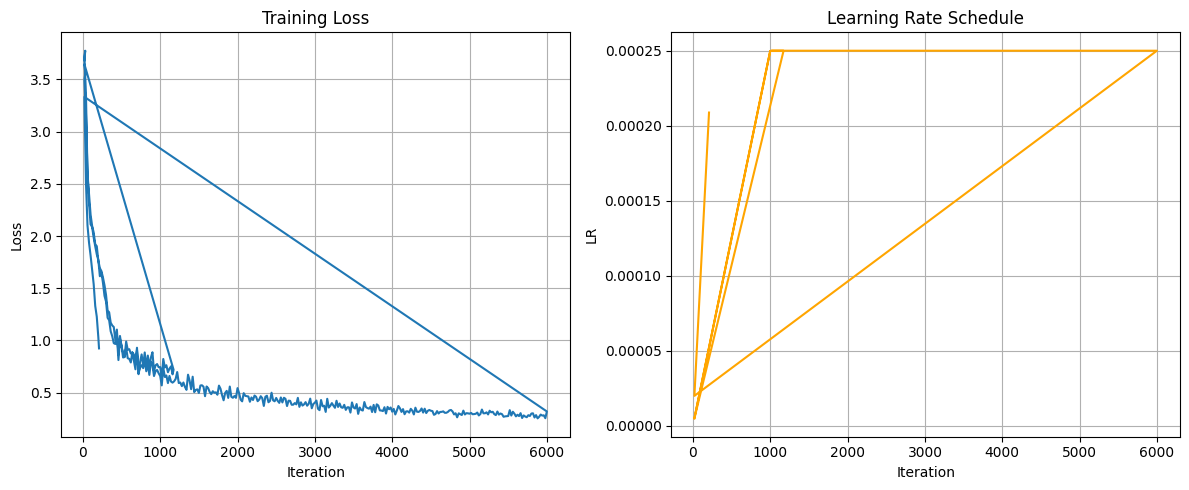

In [10]:
log_file = "./output/metrics.json"

iters = []
losses = []
lr = []

with open(log_file) as f:
    for line in f:
        record = json.loads(line)
        if "total_loss" in record:
            iters.append(record["iteration"])
            losses.append(record["total_loss"])
            lr.append(record.get("lr", None))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(iters, losses, label='Total Loss')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(iters, lr, label='Learning Rate', color='orange')
plt.xlabel("Iteration")
plt.ylabel("LR")
plt.title("Learning Rate Schedule")
plt.grid(True)

plt.tight_layout()
plt.show()


In [9]:
predictor = DefaultPredictor(cfg)

In [12]:
image_path = "jpg/self.jpg" 
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# 3. Инференс
outputs = predictor(image)

# 4. Визуализация
v = Visualizer(image_rgb, metadata=MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.0)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

# 5. Отображение
plt.figure(figsize=(12, 8))
plt.imshow(out.get_image())
plt.axis("off")
plt.show()

AssertionError: Attribute 'thing_classes' in the metadata of 'coco_2017_train' cannot be set to a different value!
['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'] != ['leaf']

In [16]:
import torch
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())


2.7.1+cu126
12.6
True
